In [6]:
!pip install mplsoccer
import mplsoccer as ms
from mplsoccer import Pitch, Sbopen, VerticalPitch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.1 MB/s eta 0:00:00


In [7]:
parser = Sbopen()
df_matches = parser.match(competition_id = 55, season_id = 282)

In [8]:
event_list = []
for match_id in df_matches.match_id.unique():
    df_event = parser.event(match_id)[0]   # [0] = event dataframe
    df_event['match_id'] = match_id
    event_list.append(df_event)

df = pd.concat(event_list, ignore_index = True)

# filtering only passes and carries
df_pass = df[df['type_name'] == 'Pass'].copy()
df_carry = df[df['type_name'] == 'Carry'].copy()

In the next section, I have defined a completed pass as 'progressive' if it meets either of these 2 conditions:

1) Moves the ball forward at least 10 meters if starting in own half, OR 5 meters if starting in opponent half.

2) Ends in the final third of the pitch

In [9]:
# goal center
GOAL_X, GOAL_Y = 120, 40

# distance to goal helper
def dist_to_goal(x, y):
    return np.sqrt((GOAL_X - x) ** 2 + (GOAL_Y - y) ** 2) #simple distance formula

# adding distance metrics
df_pass['start_dist_goal'] = dist_to_goal(df_pass['x'], df_pass['y'])
df_pass['end_dist_goal'] = dist_to_goal(df_pass['end_x'], df_pass['end_y'])
df_pass['progress_dist'] = df_pass['start_dist_goal'] - df_pass['end_dist_goal']

# progressive pass conditions
df_pass['progressive'] = (
    (df_pass.outcome_name.isnull()) & (
        (df_pass['x'] < 60) & (df_pass['progress_dist'] >= 10) |   # own half
        (df_pass['x'] >= 60) & (df_pass['progress_dist'] >= 5) |   # opp half
        (df_pass['end_x'] >= 80)                                   # into final third
    )
)

We now follow the same process for carries, defining a carry as 'progressive' if it meets either of these 2 conditions:
1) Covers a distance of more than 5m in the opposite team's half
2) Total distance covered is more than 30m (to account for long carries/solo runs)

In [10]:
# For carries: distance moved towards goal
df_carry['start_dist_goal'] = dist_to_goal(df_carry['x'], df_carry['y'])
df_carry['end_dist_goal'] = dist_to_goal(df_carry['end_x'], df_carry['end_y'])
df_carry['progress_dist'] = df_carry['start_dist_goal'] - df_carry['end_dist_goal']

df_carry['progressive'] = (
    (df_carry['progress_dist'] >= 5) & (df_carry['x'] >= 60) |     # in opp half
    (df_carry['progress_dist'] >= 30)                              # long carries
)

Now, we aggregate progressive passes and carries per player!

In [11]:
# Progressive passes per player
prog_passers = (
    df_pass[df_pass['progressive']]
    .groupby(['player_id', 'player_name', 'team_name'])
    .size()
    .reset_index(name='prog_passes')
    .sort_values('prog_passes', ascending = False)
)

# Progressive carries per player
prog_carriers = (
    df_carry[df_carry['progressive']]
    .groupby(['player_id', 'player_name'])
    .size()
    .reset_index(name='prog_carries')
    .sort_values('prog_carries', ascending = False)
)

We now have each player's total progressive passes and carries. As a natural next step, it makes sense to also calculate these metrics per 90 minutes to gain insights about the efficiency of these passes/carries; Kroos may have more progressive passes than, say, Yamal, but this may just have been a result of more minutes on the pitch.

Of course, it can be argued that more minutes on the pitch is also an indicator of the player's ability and the coach's trust in them, so I've added a separate column for metrics/90 along with the already calculated total passes/carries.

A player’s total minutes played have been estimated by subtracting the absolute minute of their first event from that of their last event in a game (and then doing this for each game they played). While this may slightly undercount time if a player remained on the pitch after their final recorded action, it provides a reasonable approximation for our analysis.

In [12]:
# converting period + minute + second into absolute minutes
def get_absolute_minute(row):
    if row['period'] == 1:
        return row['minute'] + row['second']/60
    elif row['period'] == 2:
        return 45 + row['minute'] + row['second']/60
    elif row['period'] == 3:  # 1H extra time
        return 90 + row['minute'] + row['second']/60
    elif row['period'] == 4:  # 2H extra time
        return 105 + row['minute'] + row['second']/60
    else:
        return row['minute'] + row['second']/60

df['abs_minute'] = df.apply(get_absolute_minute, axis=1)

# Compute minutes per match per player
player_minutes = (
    df.groupby(['player_id', 'player_name', 'match_id'])
      .agg(first_min=('abs_minute', 'min'),
           last_min=('abs_minute', 'max'))
      .reset_index()
)

# total minutes played per match
player_minutes['minutes_played'] = player_minutes['last_min'] - player_minutes['first_min']

# sum across tournament
total_minutes = player_minutes.groupby(['player_id', 'player_name']).minutes_played.sum().round(2).reset_index()

Now, we merge total minutes into our progressive passers/carriers dataframes and calculate metrics/90

In [13]:
prog_passers = prog_passers.merge(total_minutes, on=['player_id', 'player_name'], how='left')
prog_carriers = prog_carriers.merge(total_minutes, on=['player_id', 'player_name'], how='left')

In [14]:
prog_passers['passes_per_90'] = (prog_passers['prog_passes'] / prog_passers['minutes_played']) * 90
prog_carriers['carries_per_90'] = (prog_carriers['prog_carries'] / prog_carriers['minutes_played']) * 90

In [29]:
min_minutes = 180  # only considering players with ≥ 150 mins

leaderboard_passes = prog_passers[prog_passers['minutes_played'] >= min_minutes].sort_values('passes_per_90', ascending = False)
leaderboard_carries = prog_carriers[prog_carriers['minutes_played'] >= min_minutes].sort_values('carries_per_90', ascending = False)

Heat maps for top progressive passers and carriers in the next section

In [16]:
# merging minutes_played from total_minutes dataframe
df_pass = df_pass.merge(total_minutes[['player_id', 'minutes_played']], on = 'player_id', how = 'left')
df_carry = df_carry.merge(total_minutes[['player_id', 'minutes_played']], on = 'player_id', how = 'left')

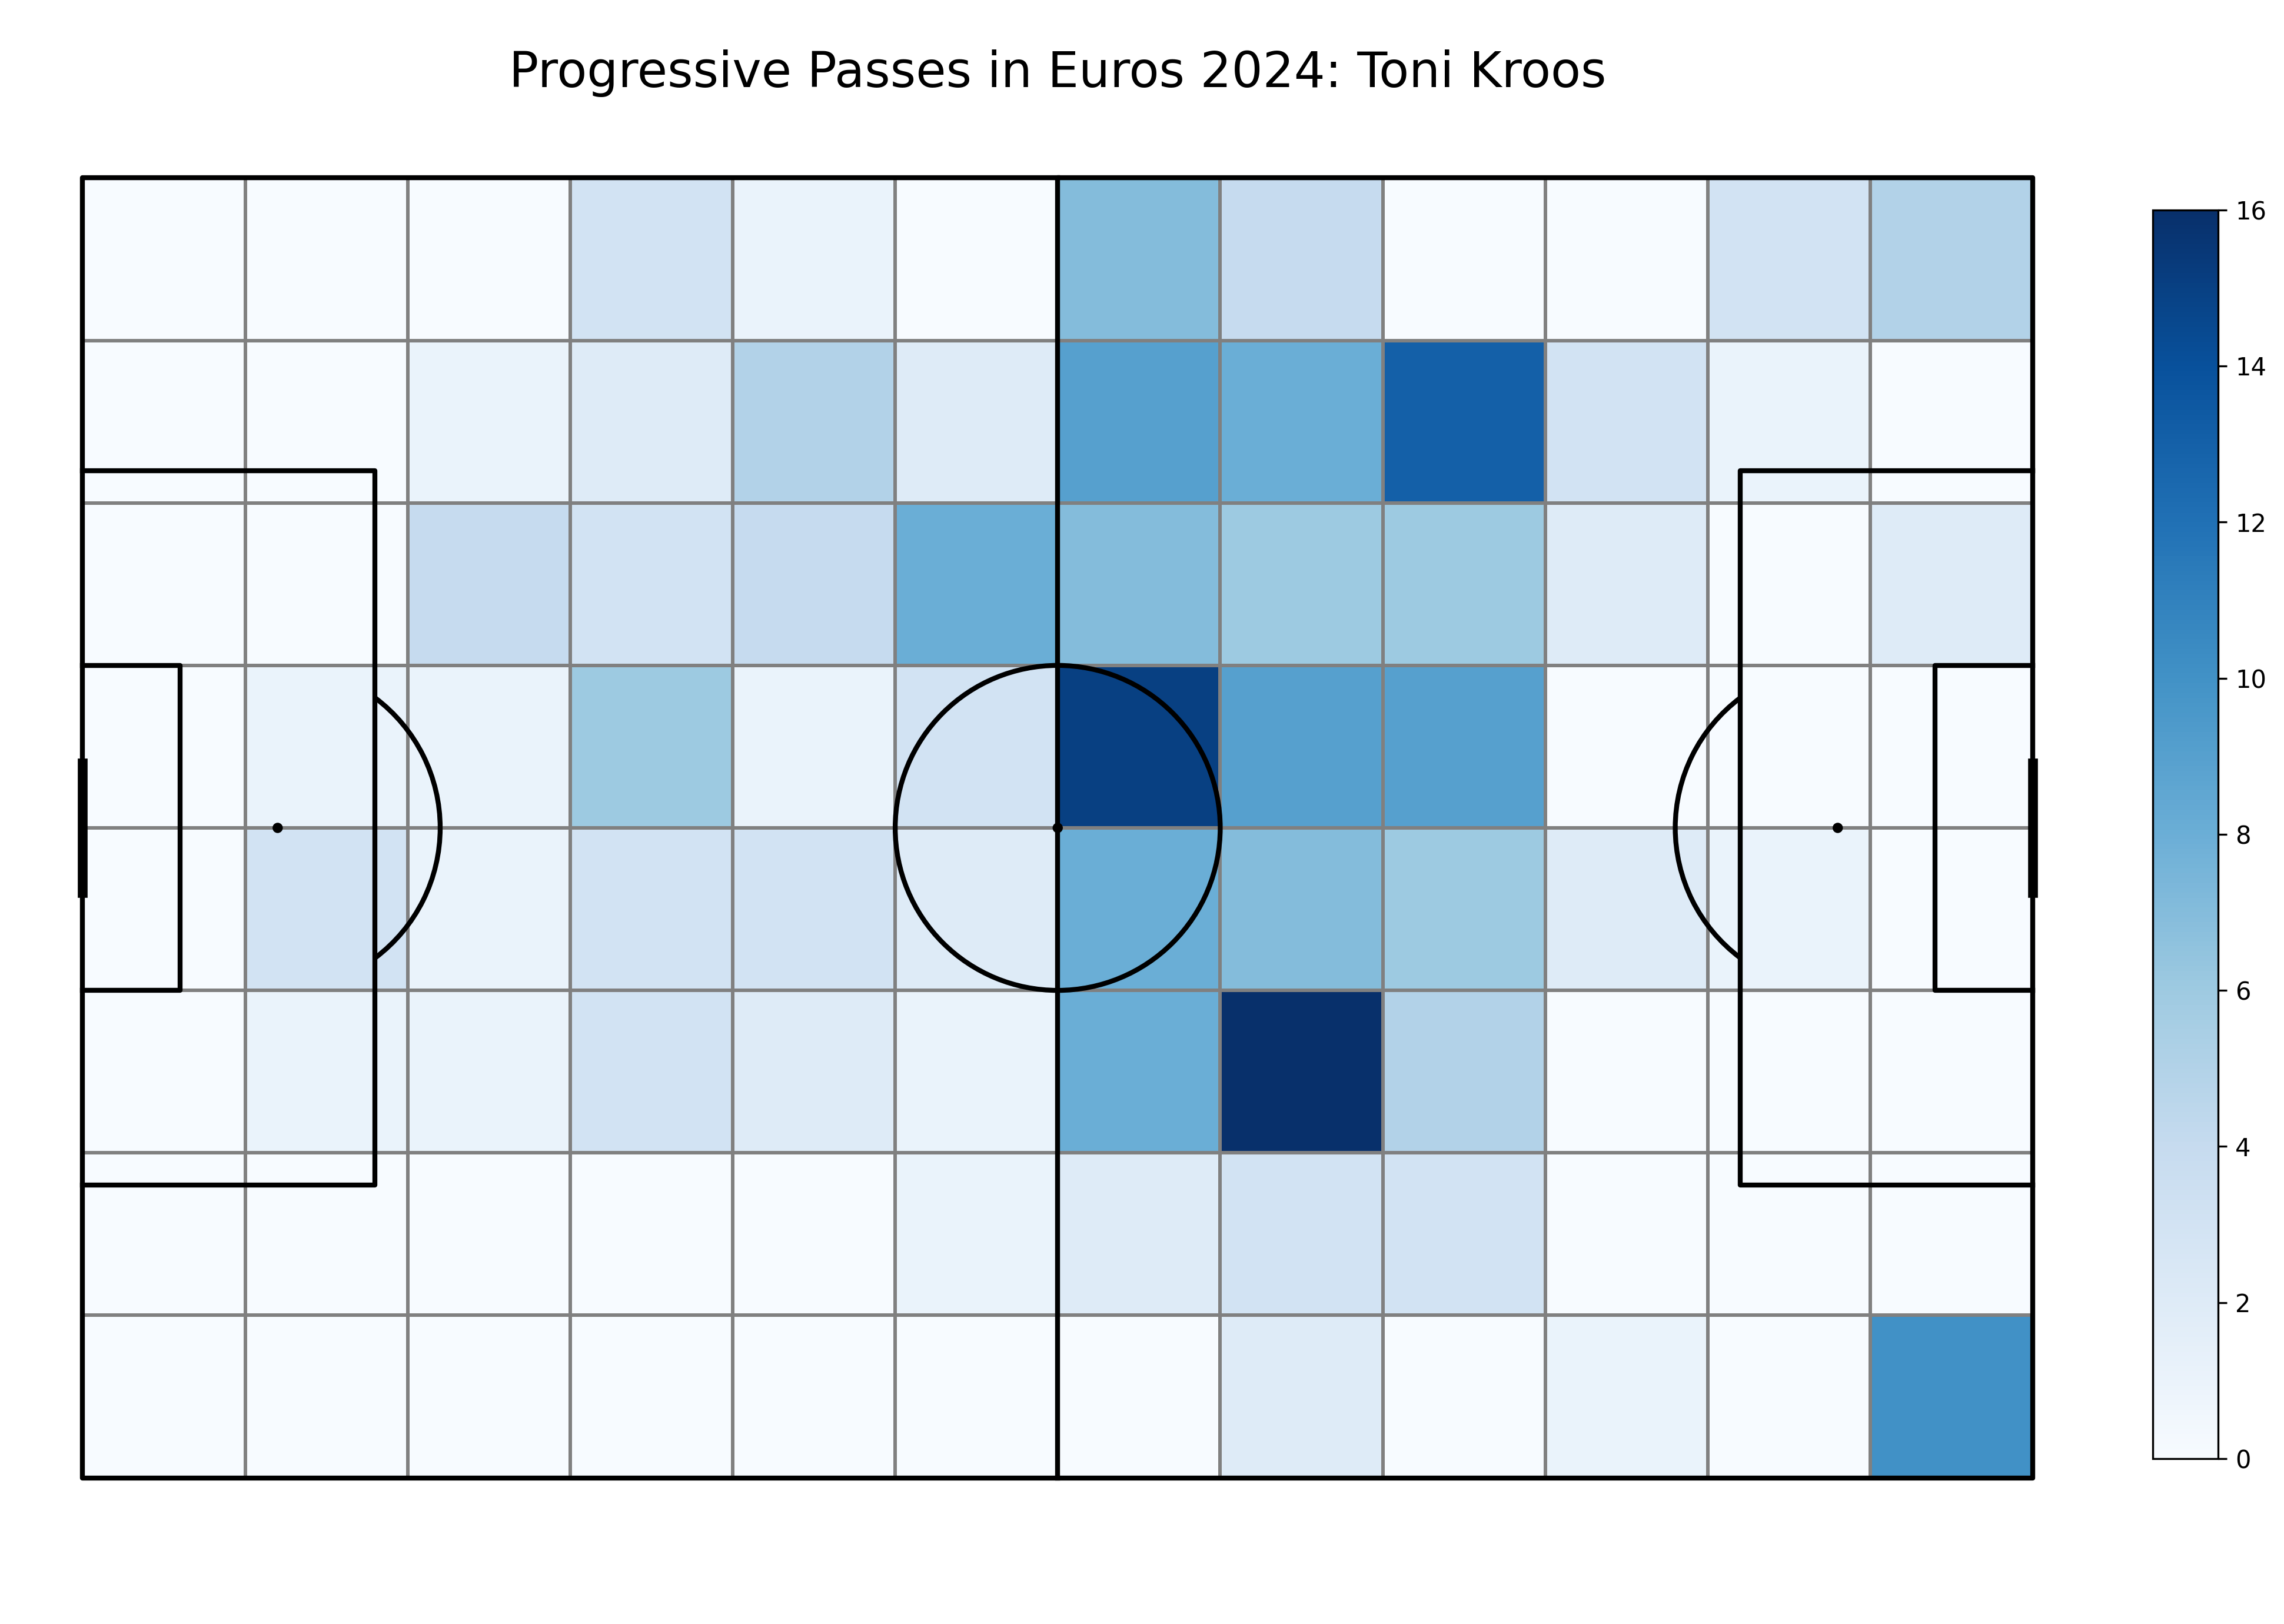

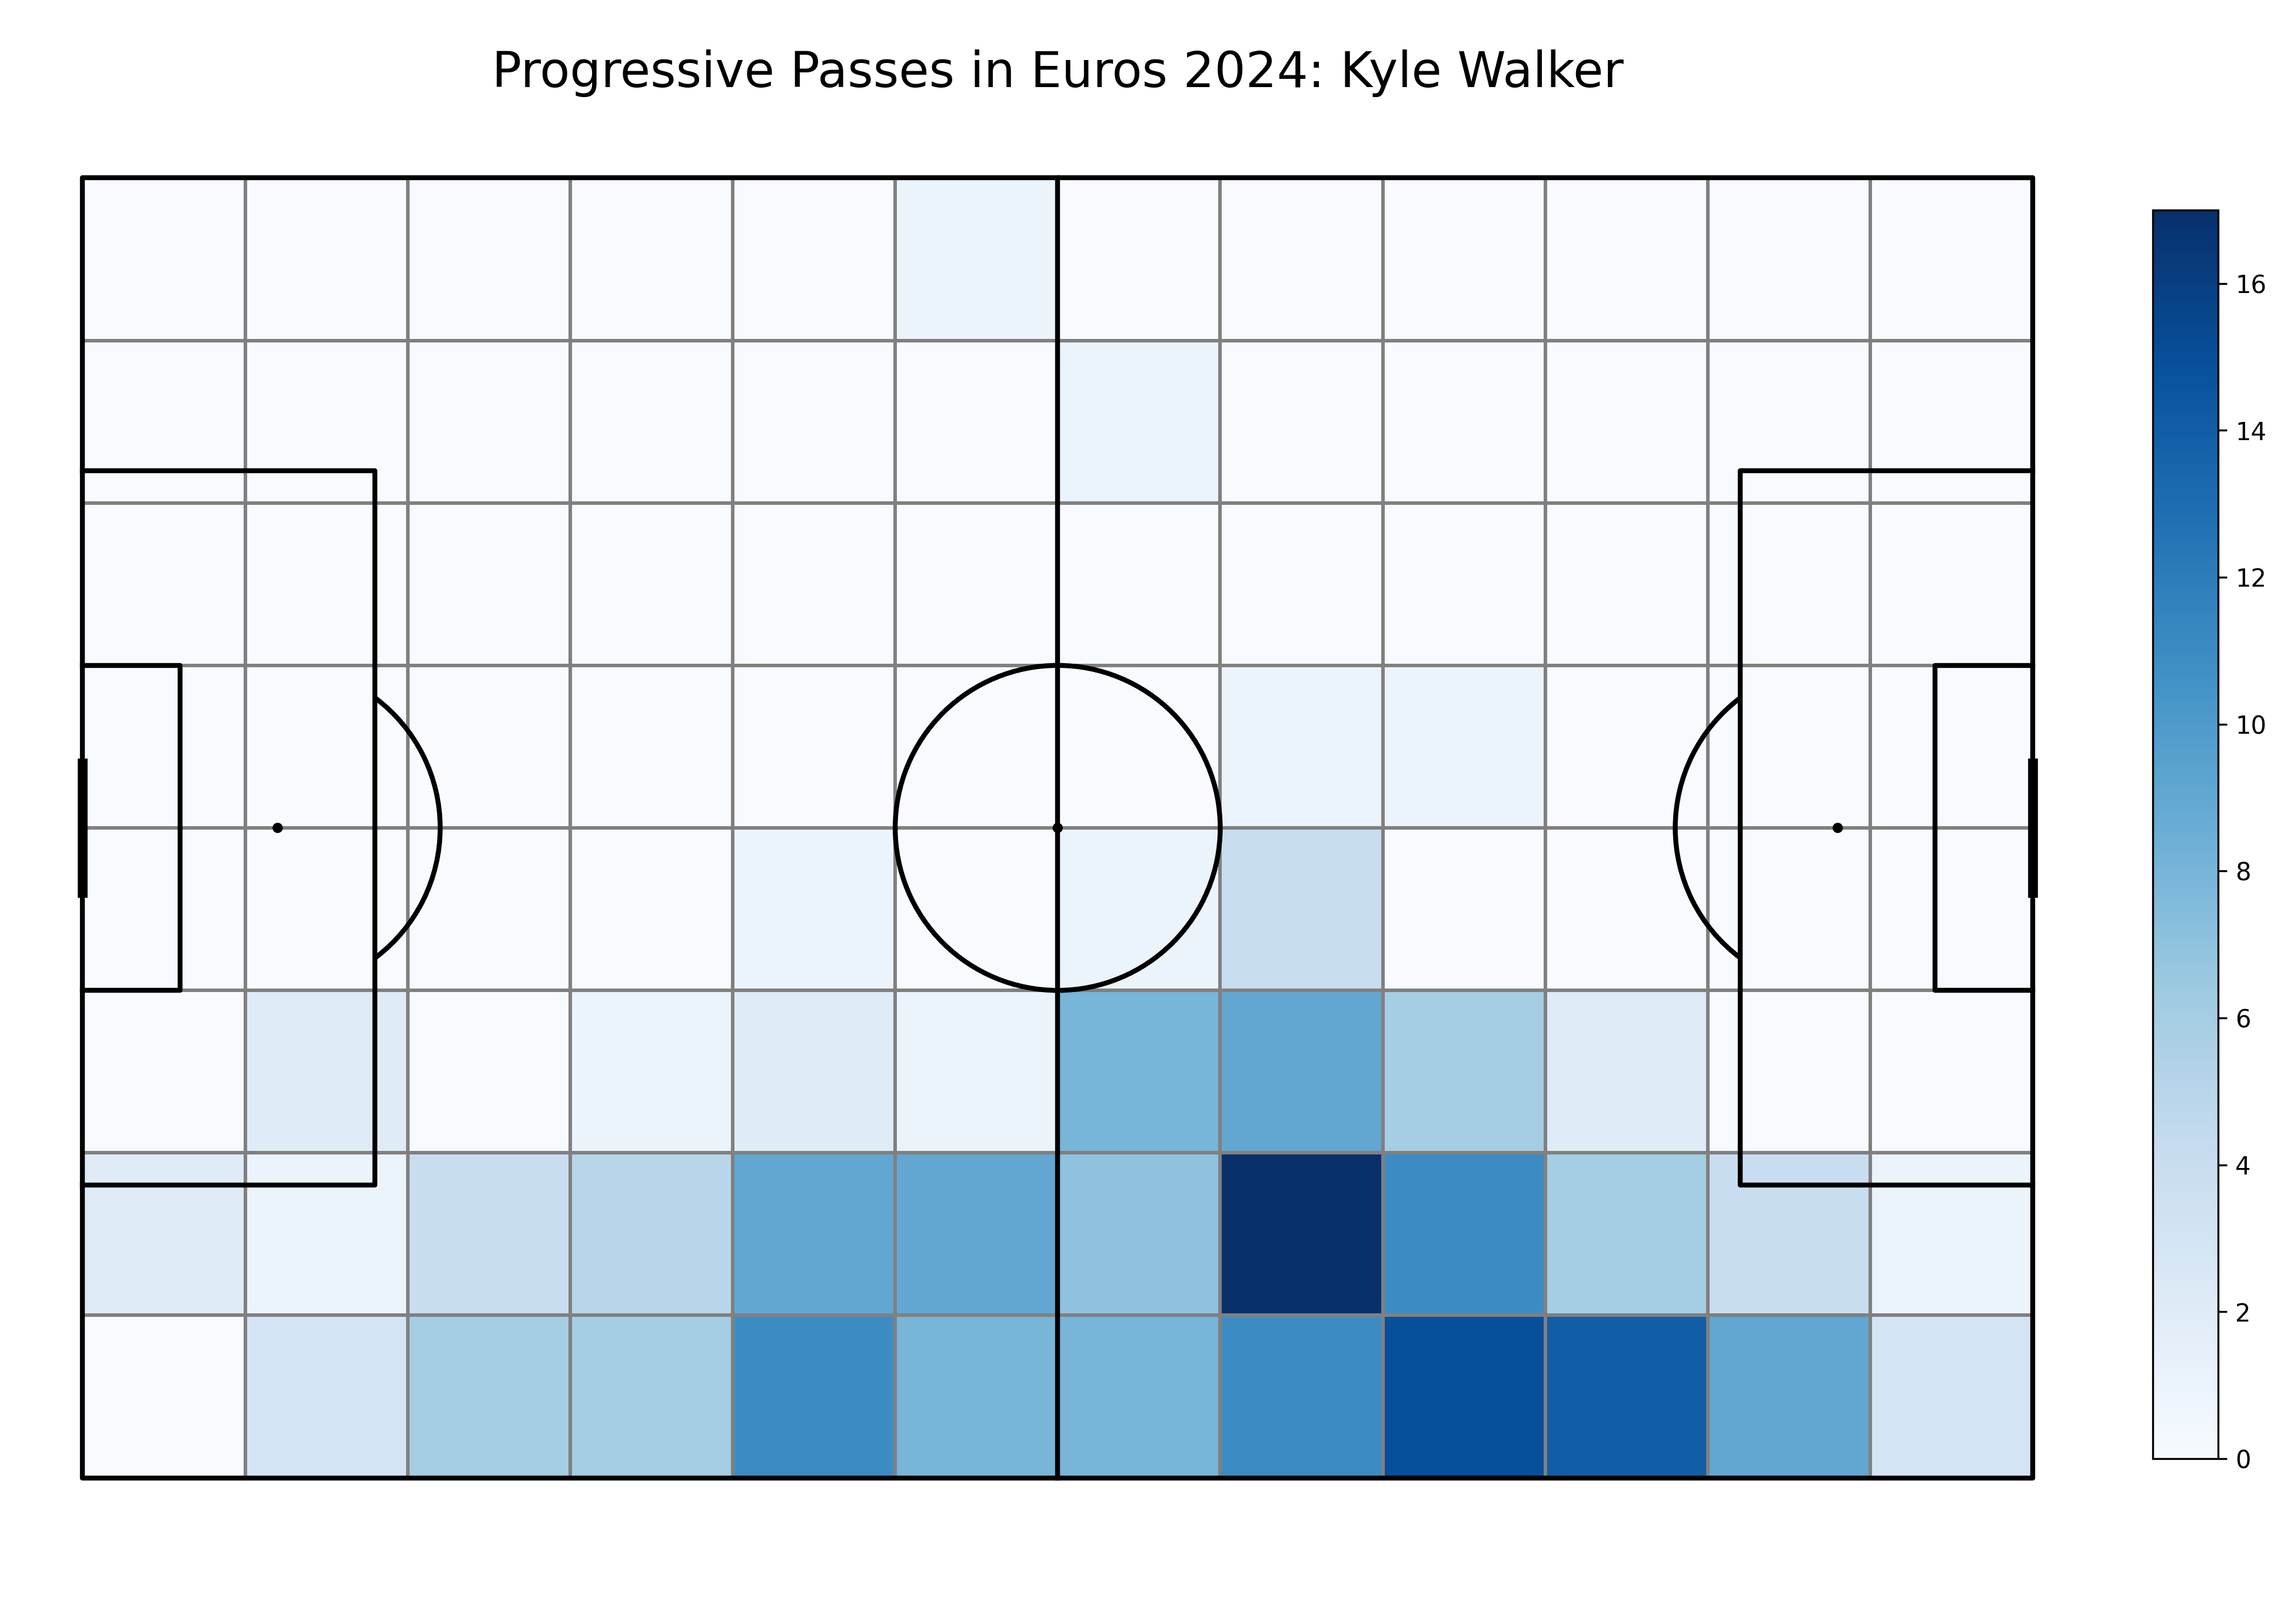

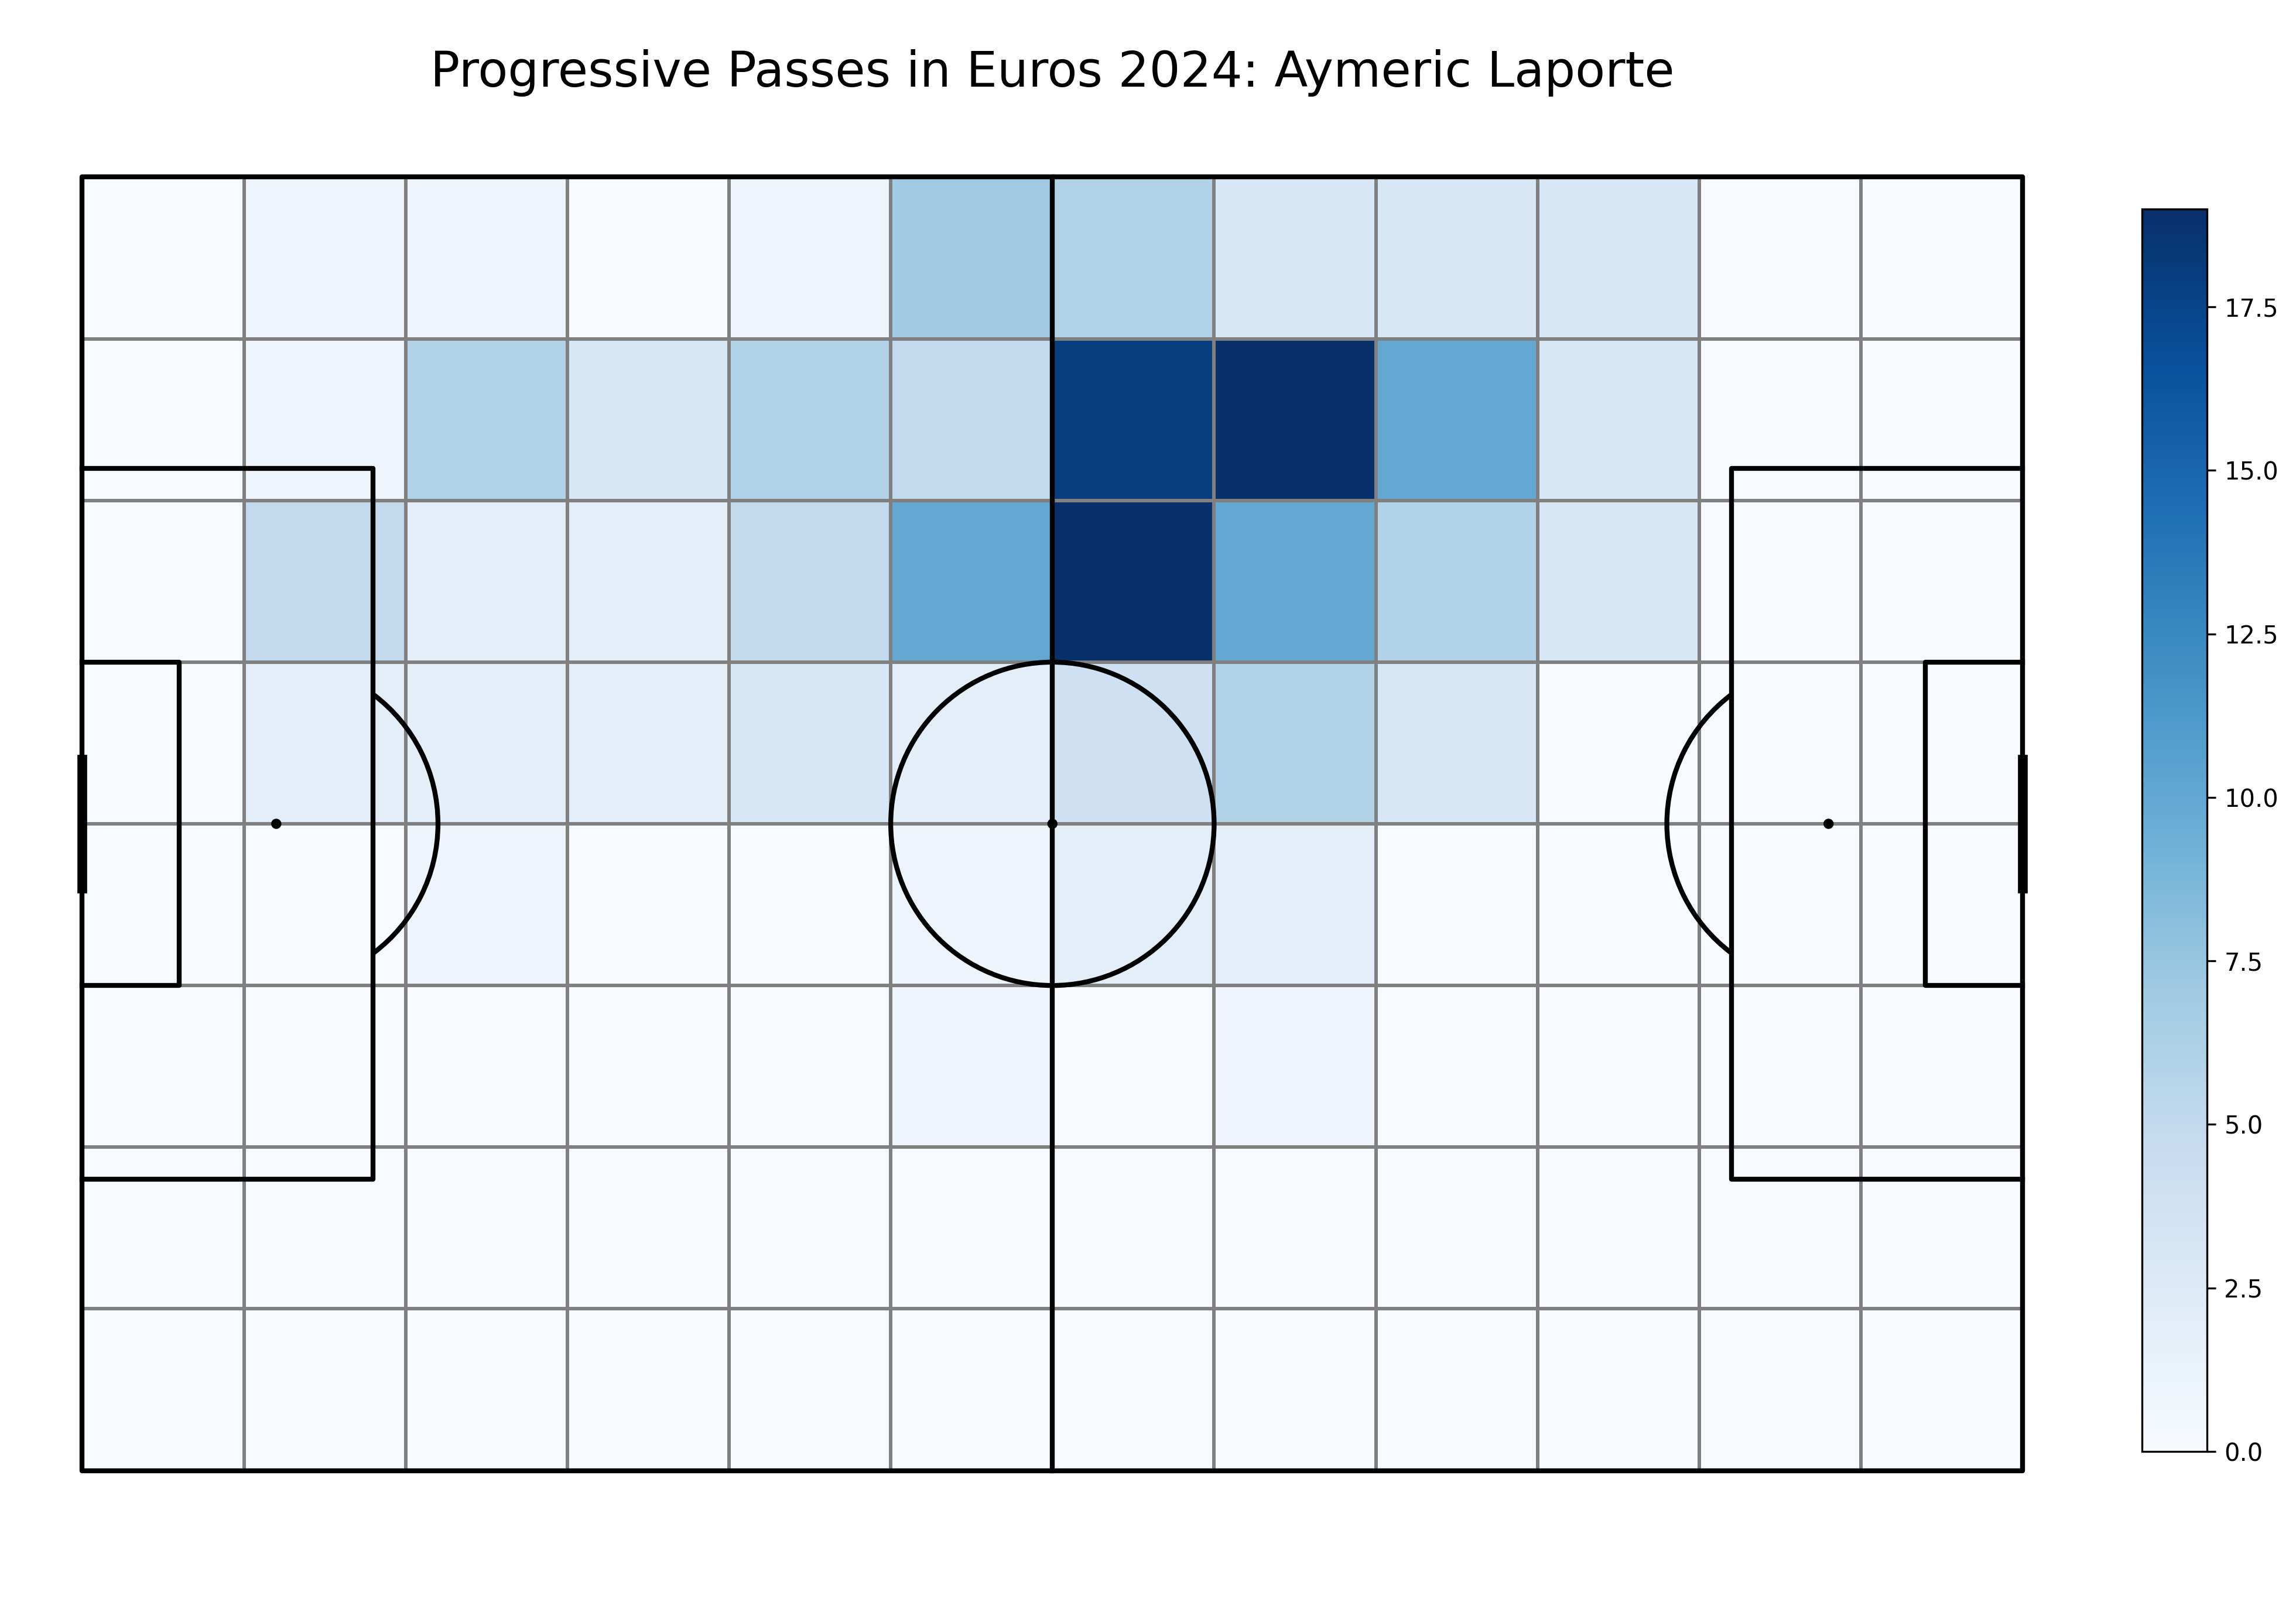

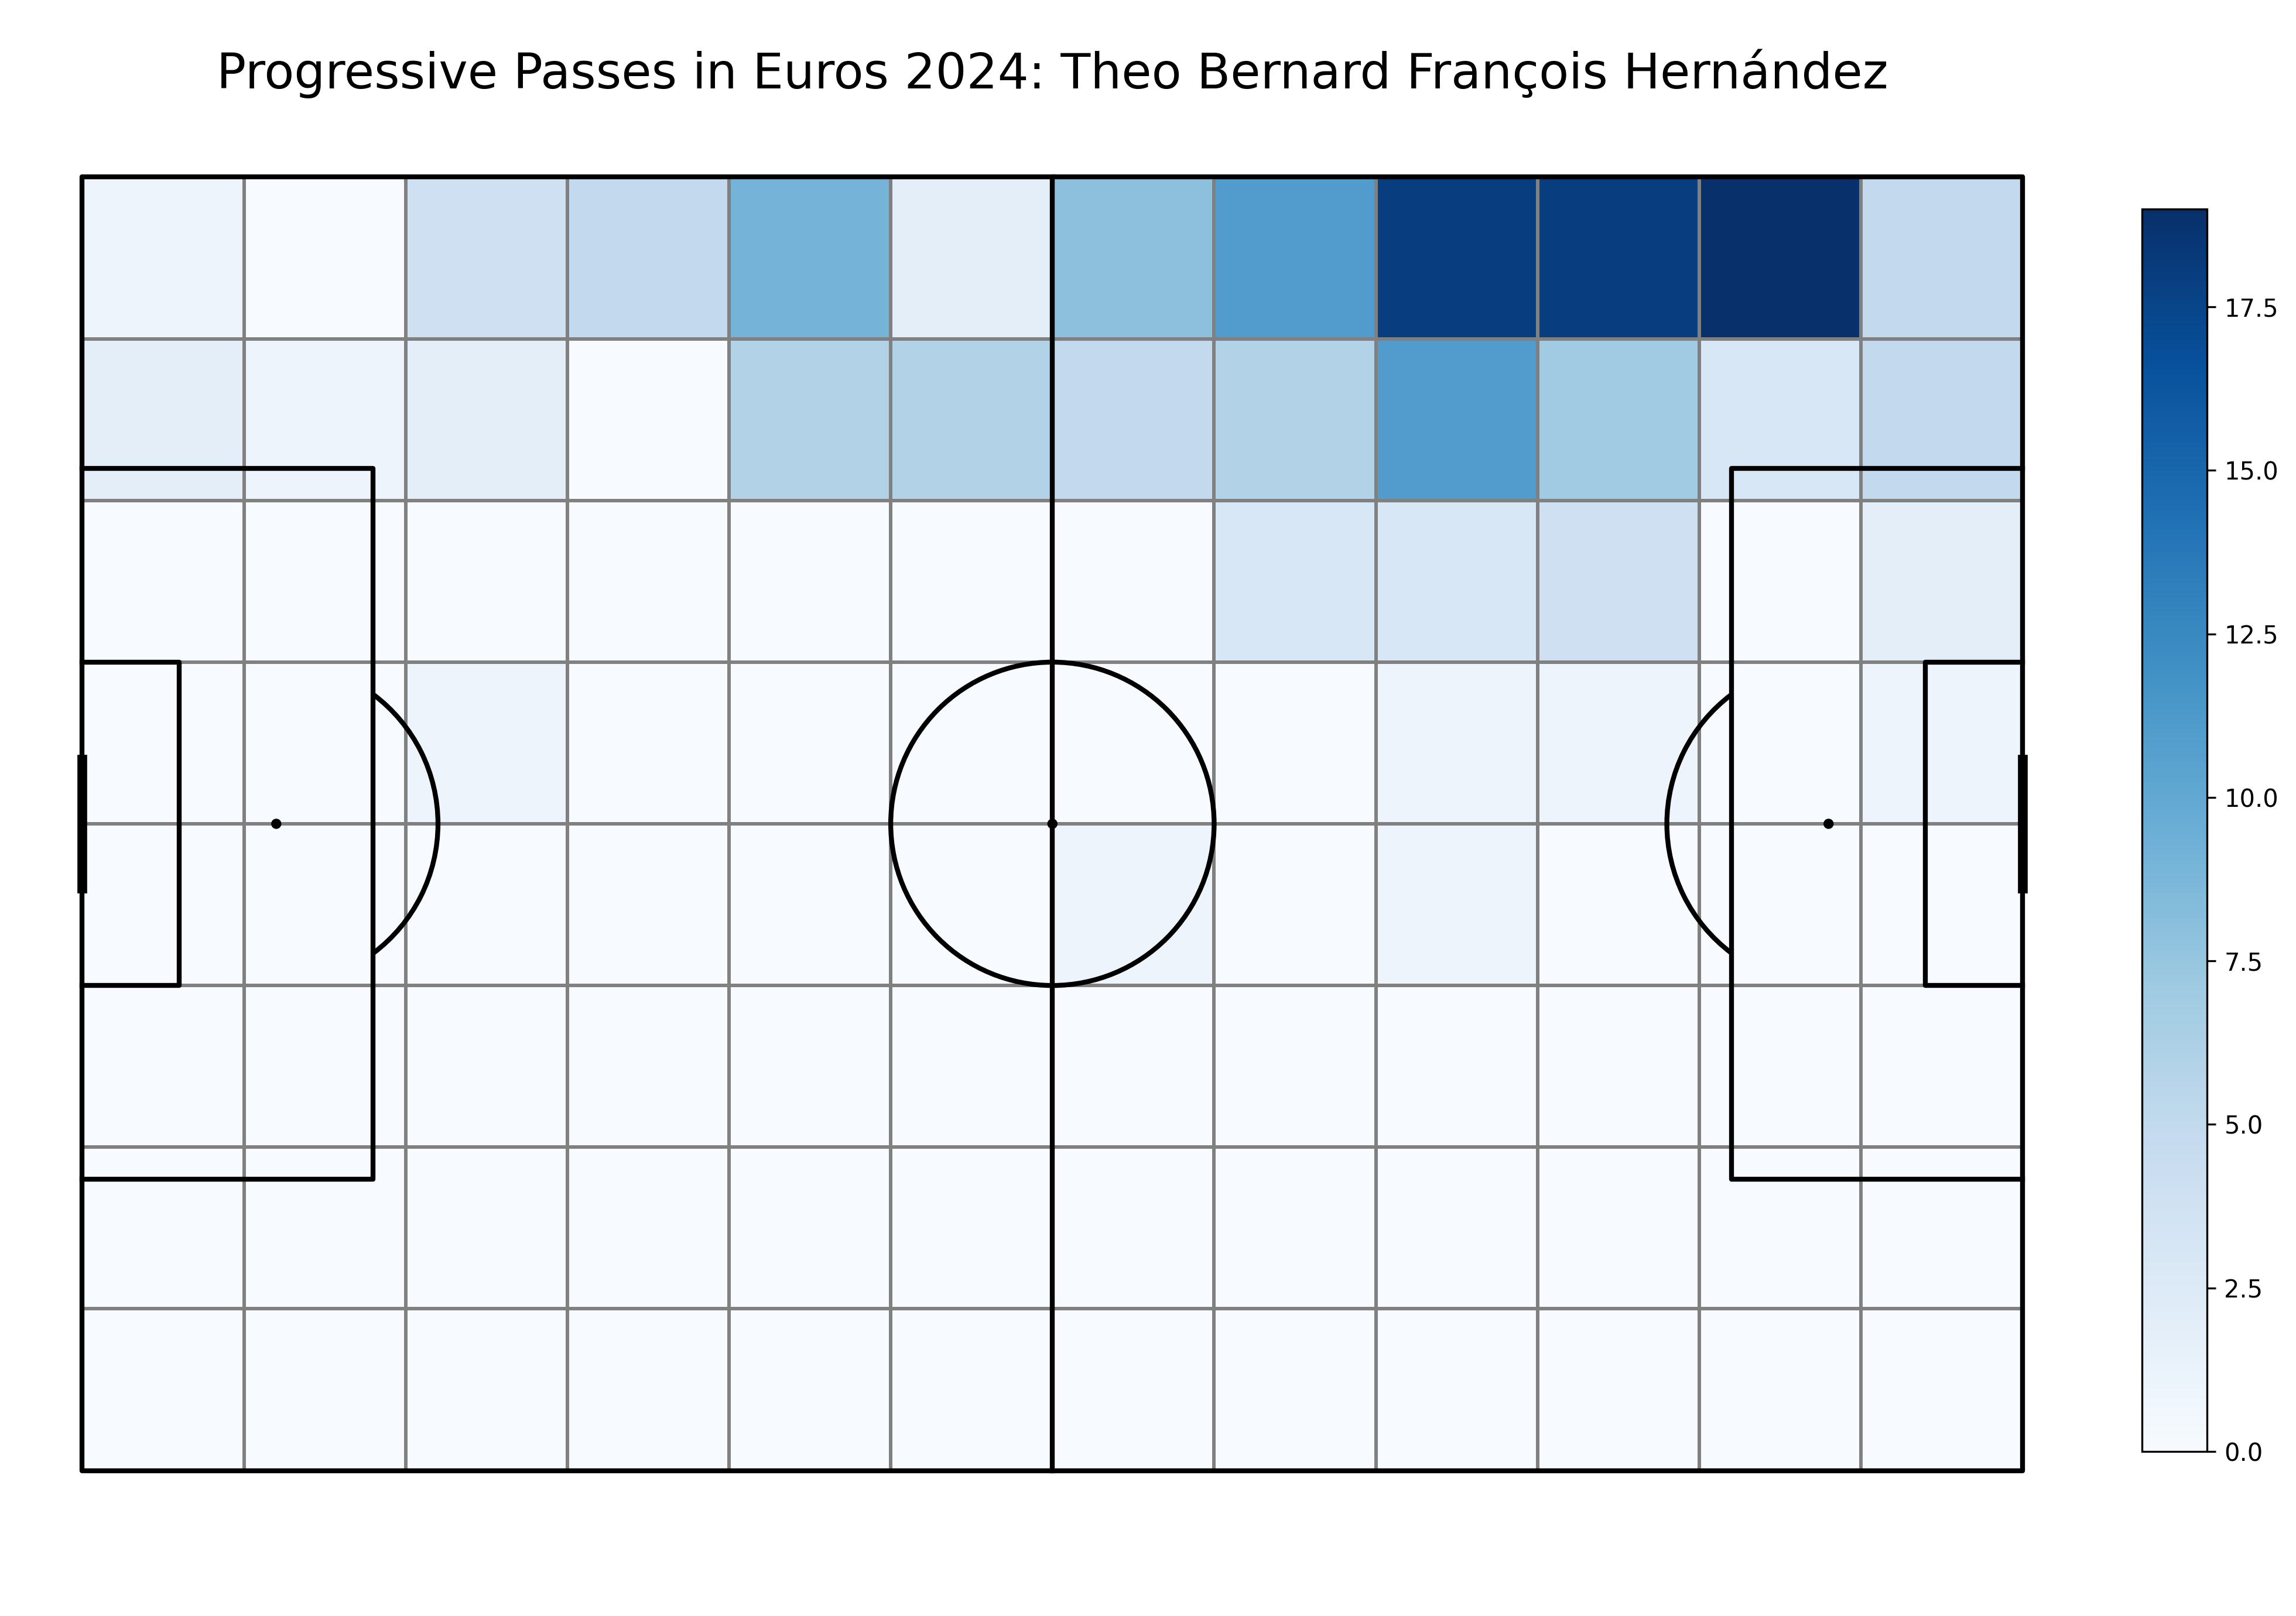

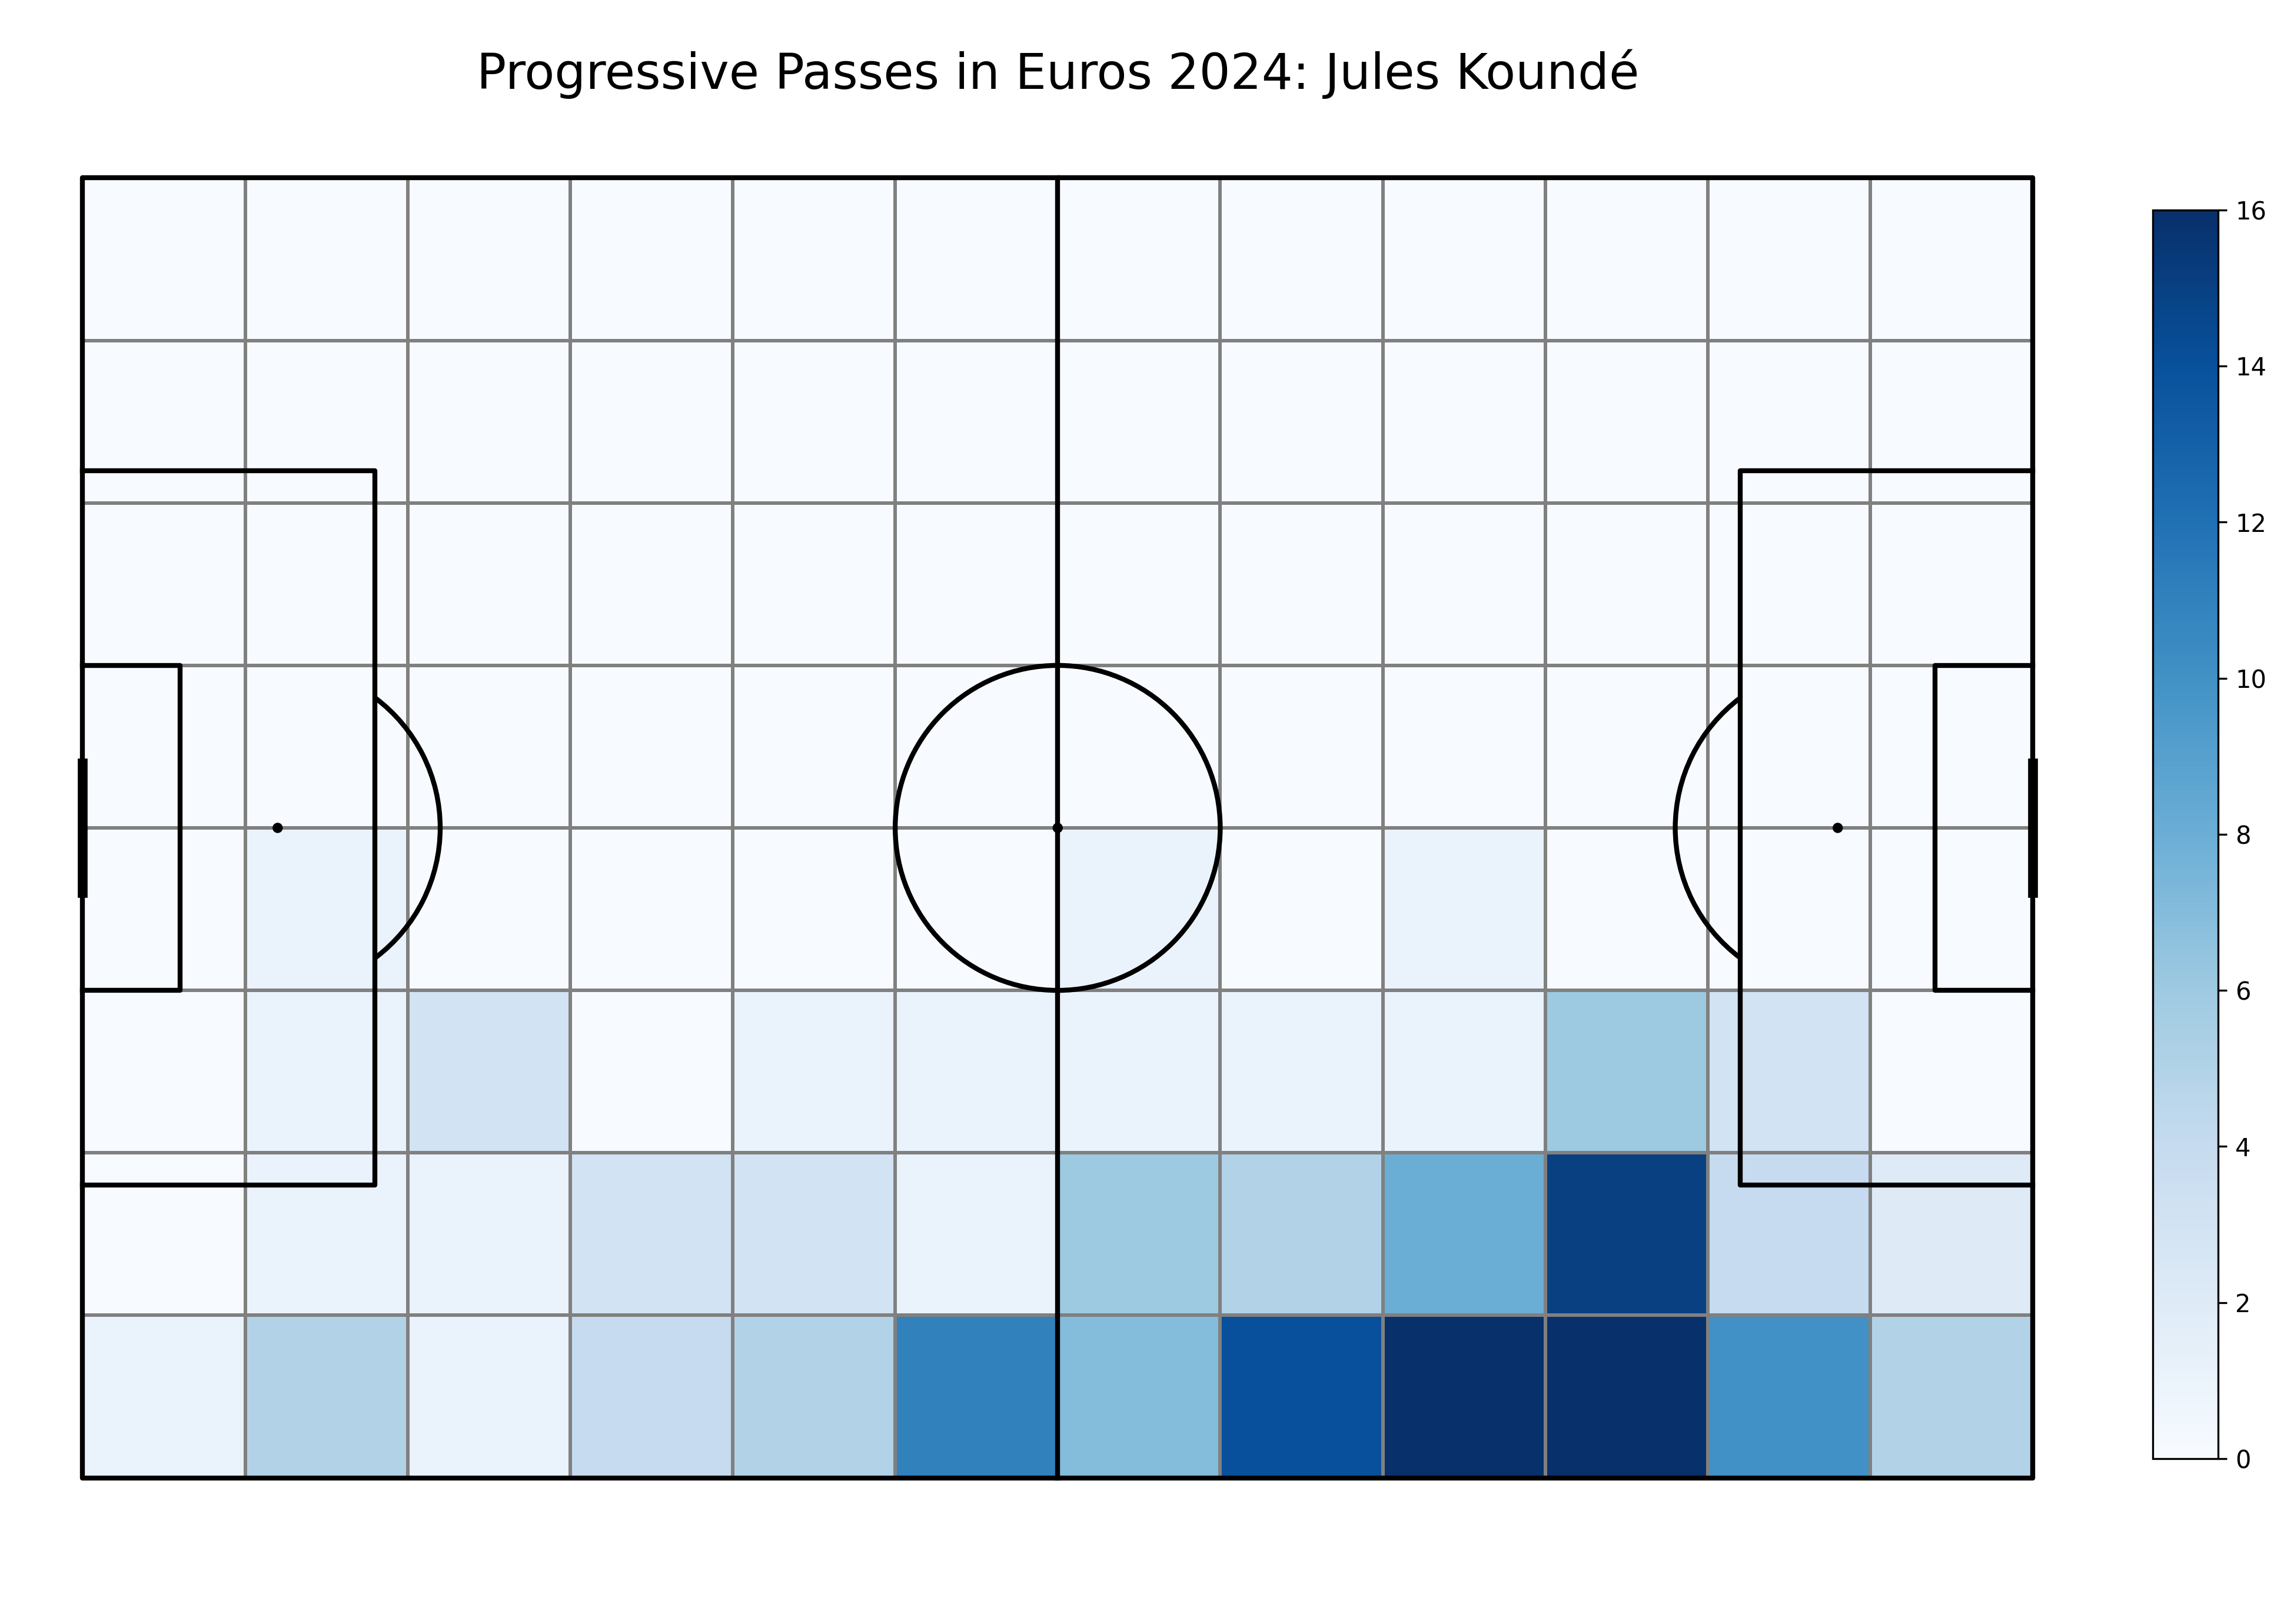

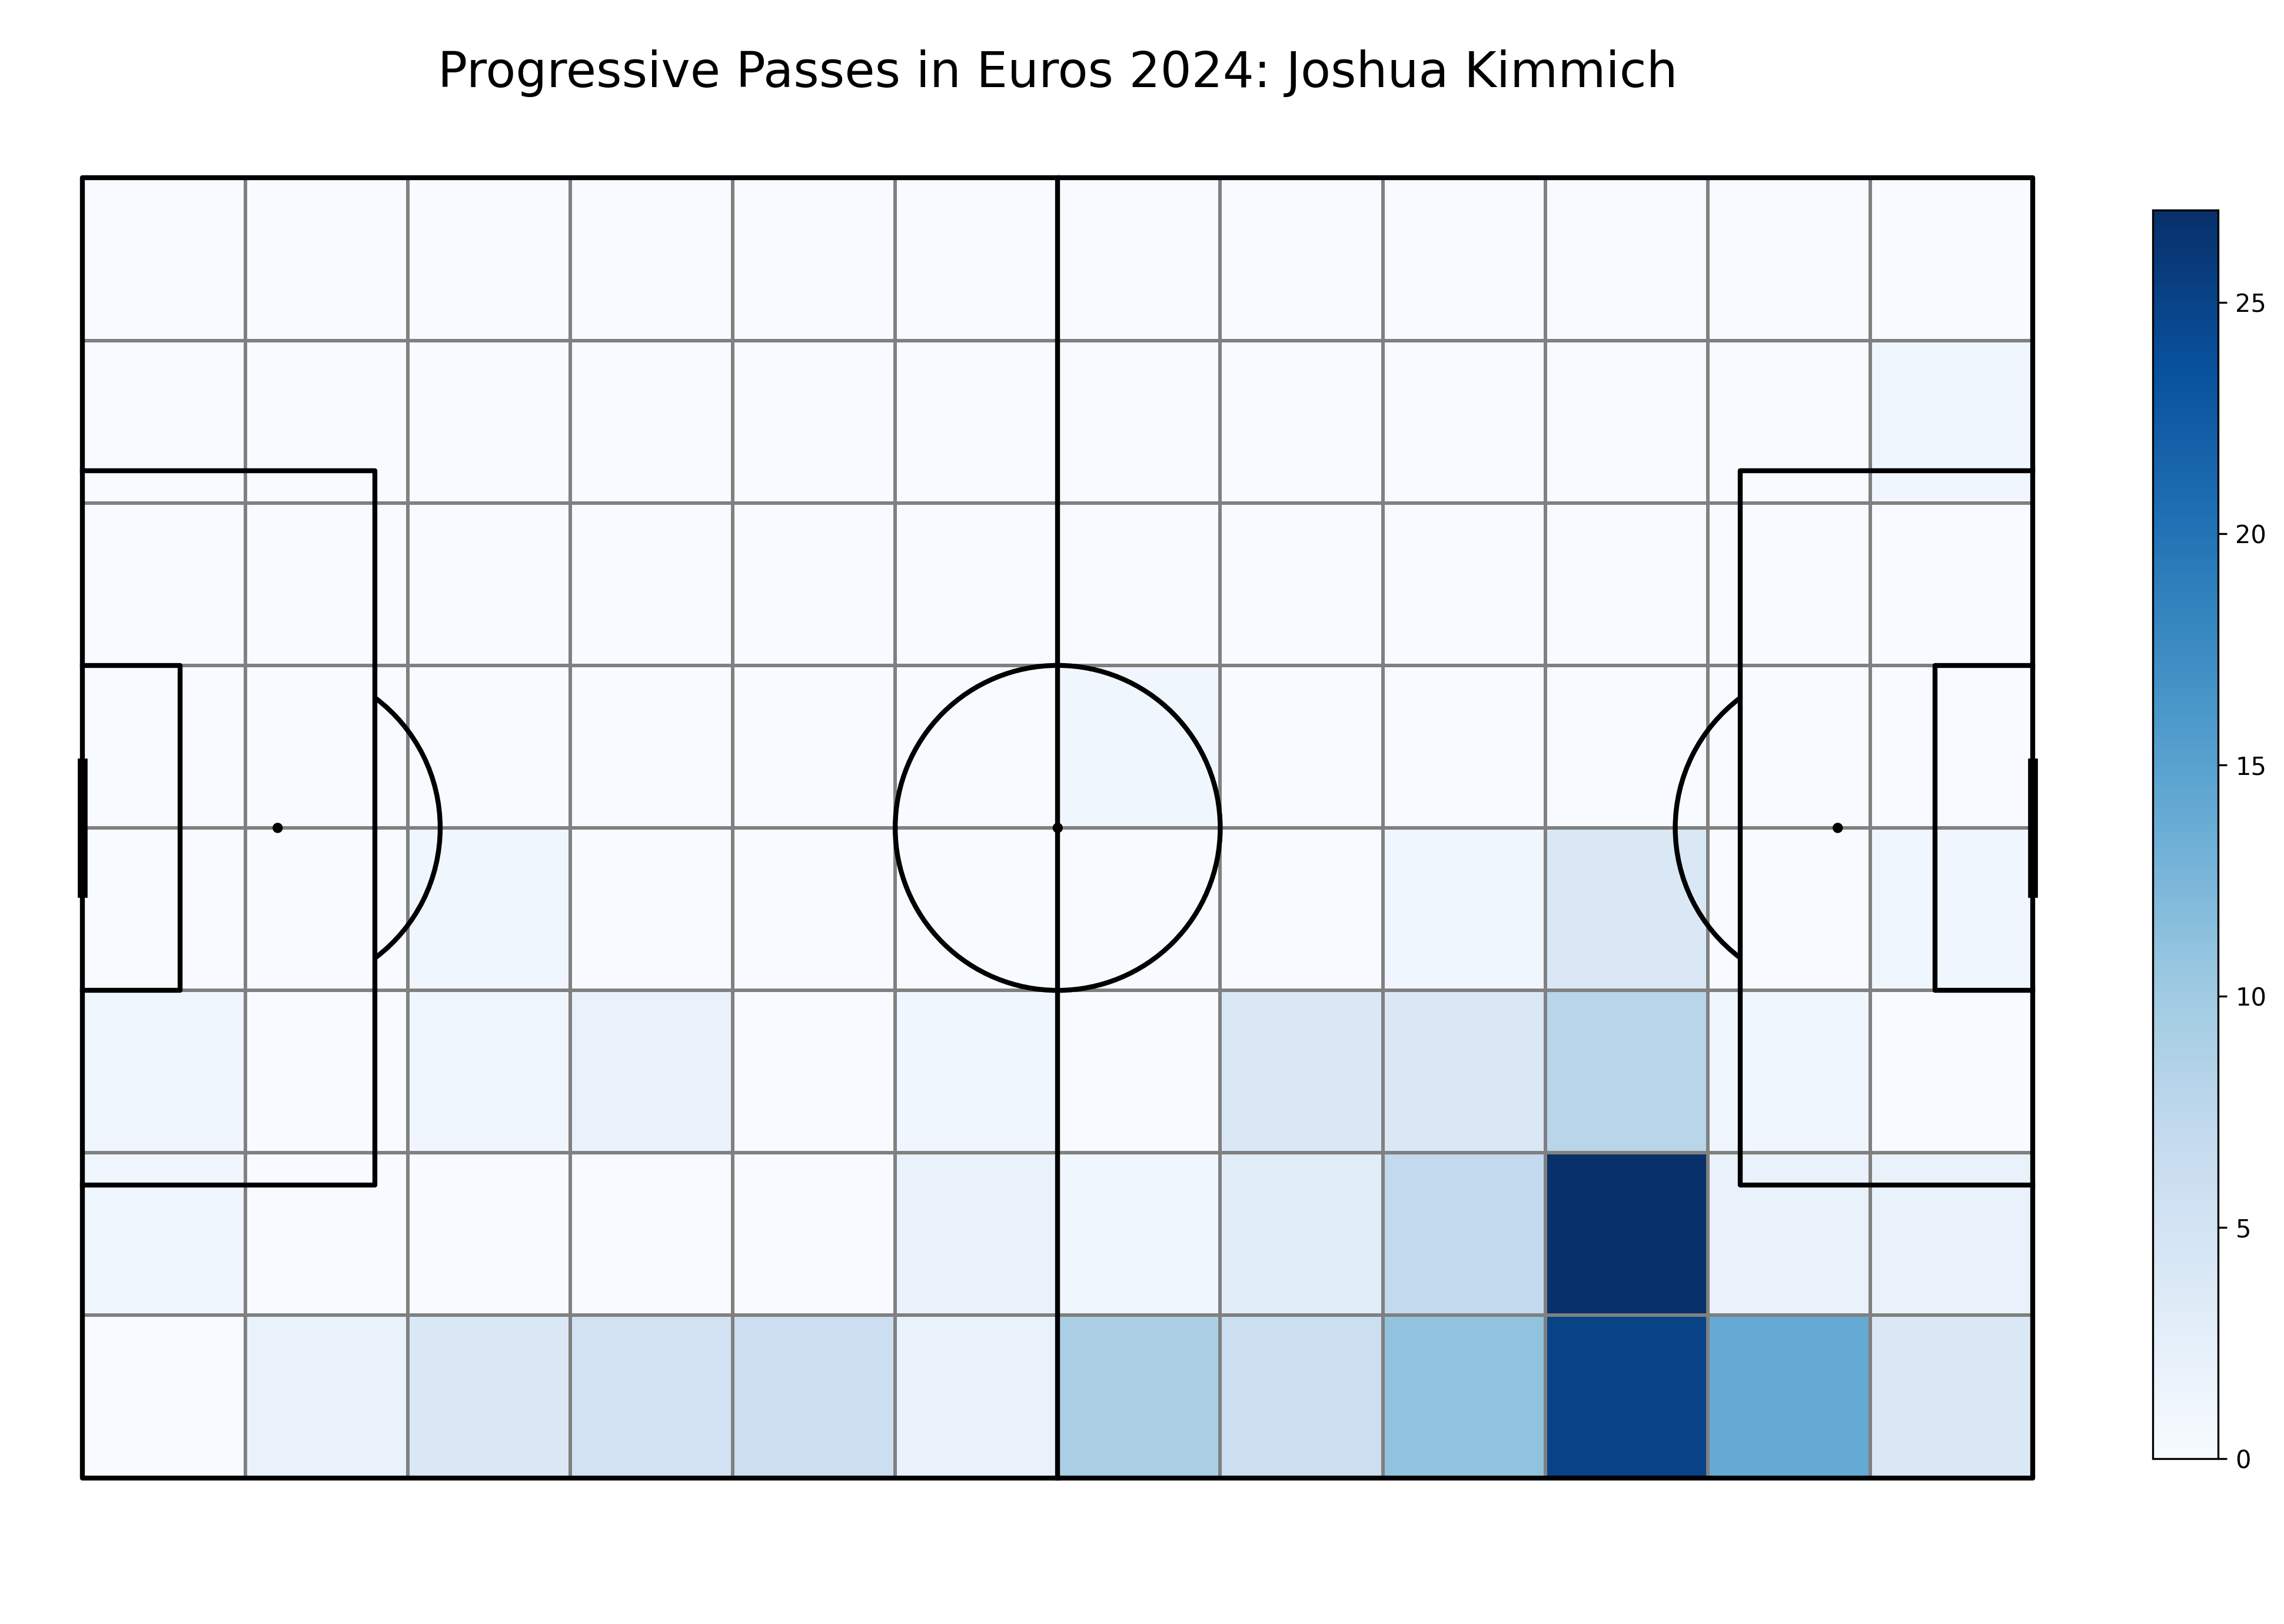

In [17]:
top6_passers = prog_passers.sort_values('prog_passes', ascending = False).head(6)['player_name'].tolist()

# plotting individually
for player in top6_passers:
    # filtering event-level df
    player_df = df_pass[(df_pass['player_name'] == player) & (df_pass['progressive'])]

    # creating pitch
    pitch = Pitch(line_zorder=2, line_color='black')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    fig.set_dpi(300)

    # 2D histogram
    bin_statistic = pitch.bin_statistic(player_df.x, player_df.y, statistic='count', bins=(12,8), normalize=False)

    # heatmap
    pcm = pitch.heatmap(bin_statistic, cmap='Blues', edgecolor='#808080', ax=ax['pitch'])

    # colorbar
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)

    # title
    fig.suptitle('Progressive Passes in Euros 2024: ' + player, fontsize=20)
    plt.show()

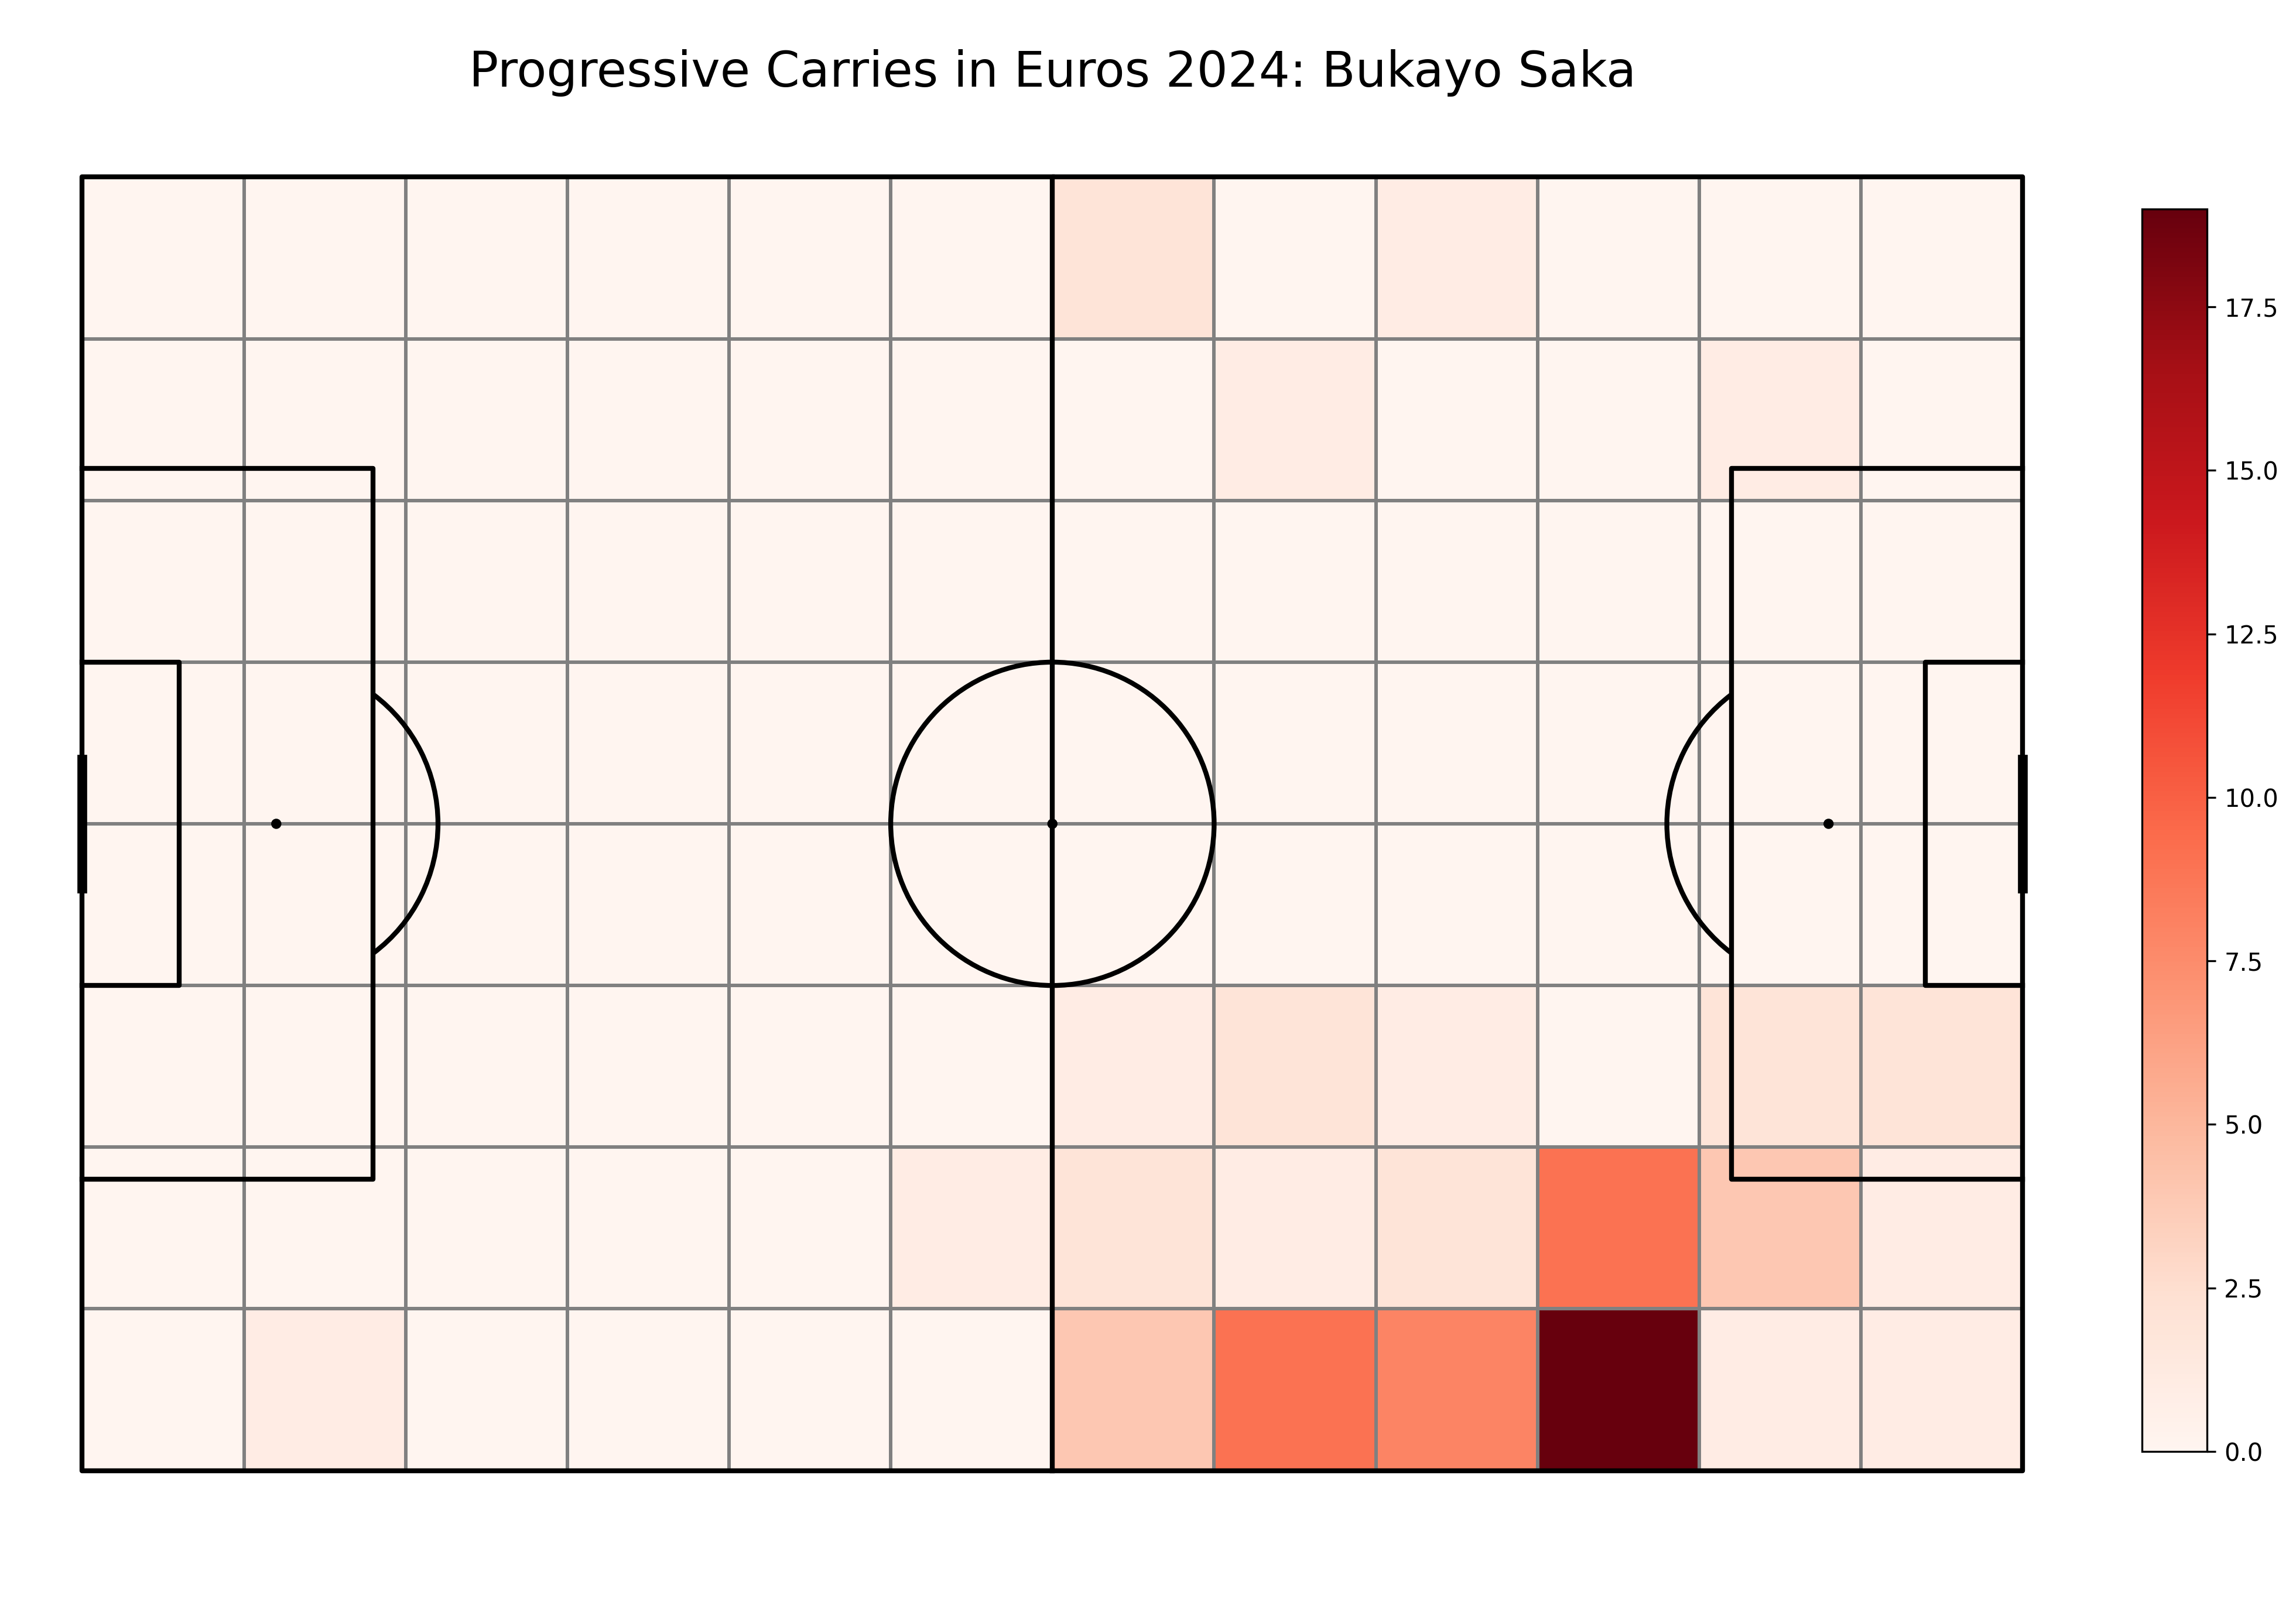

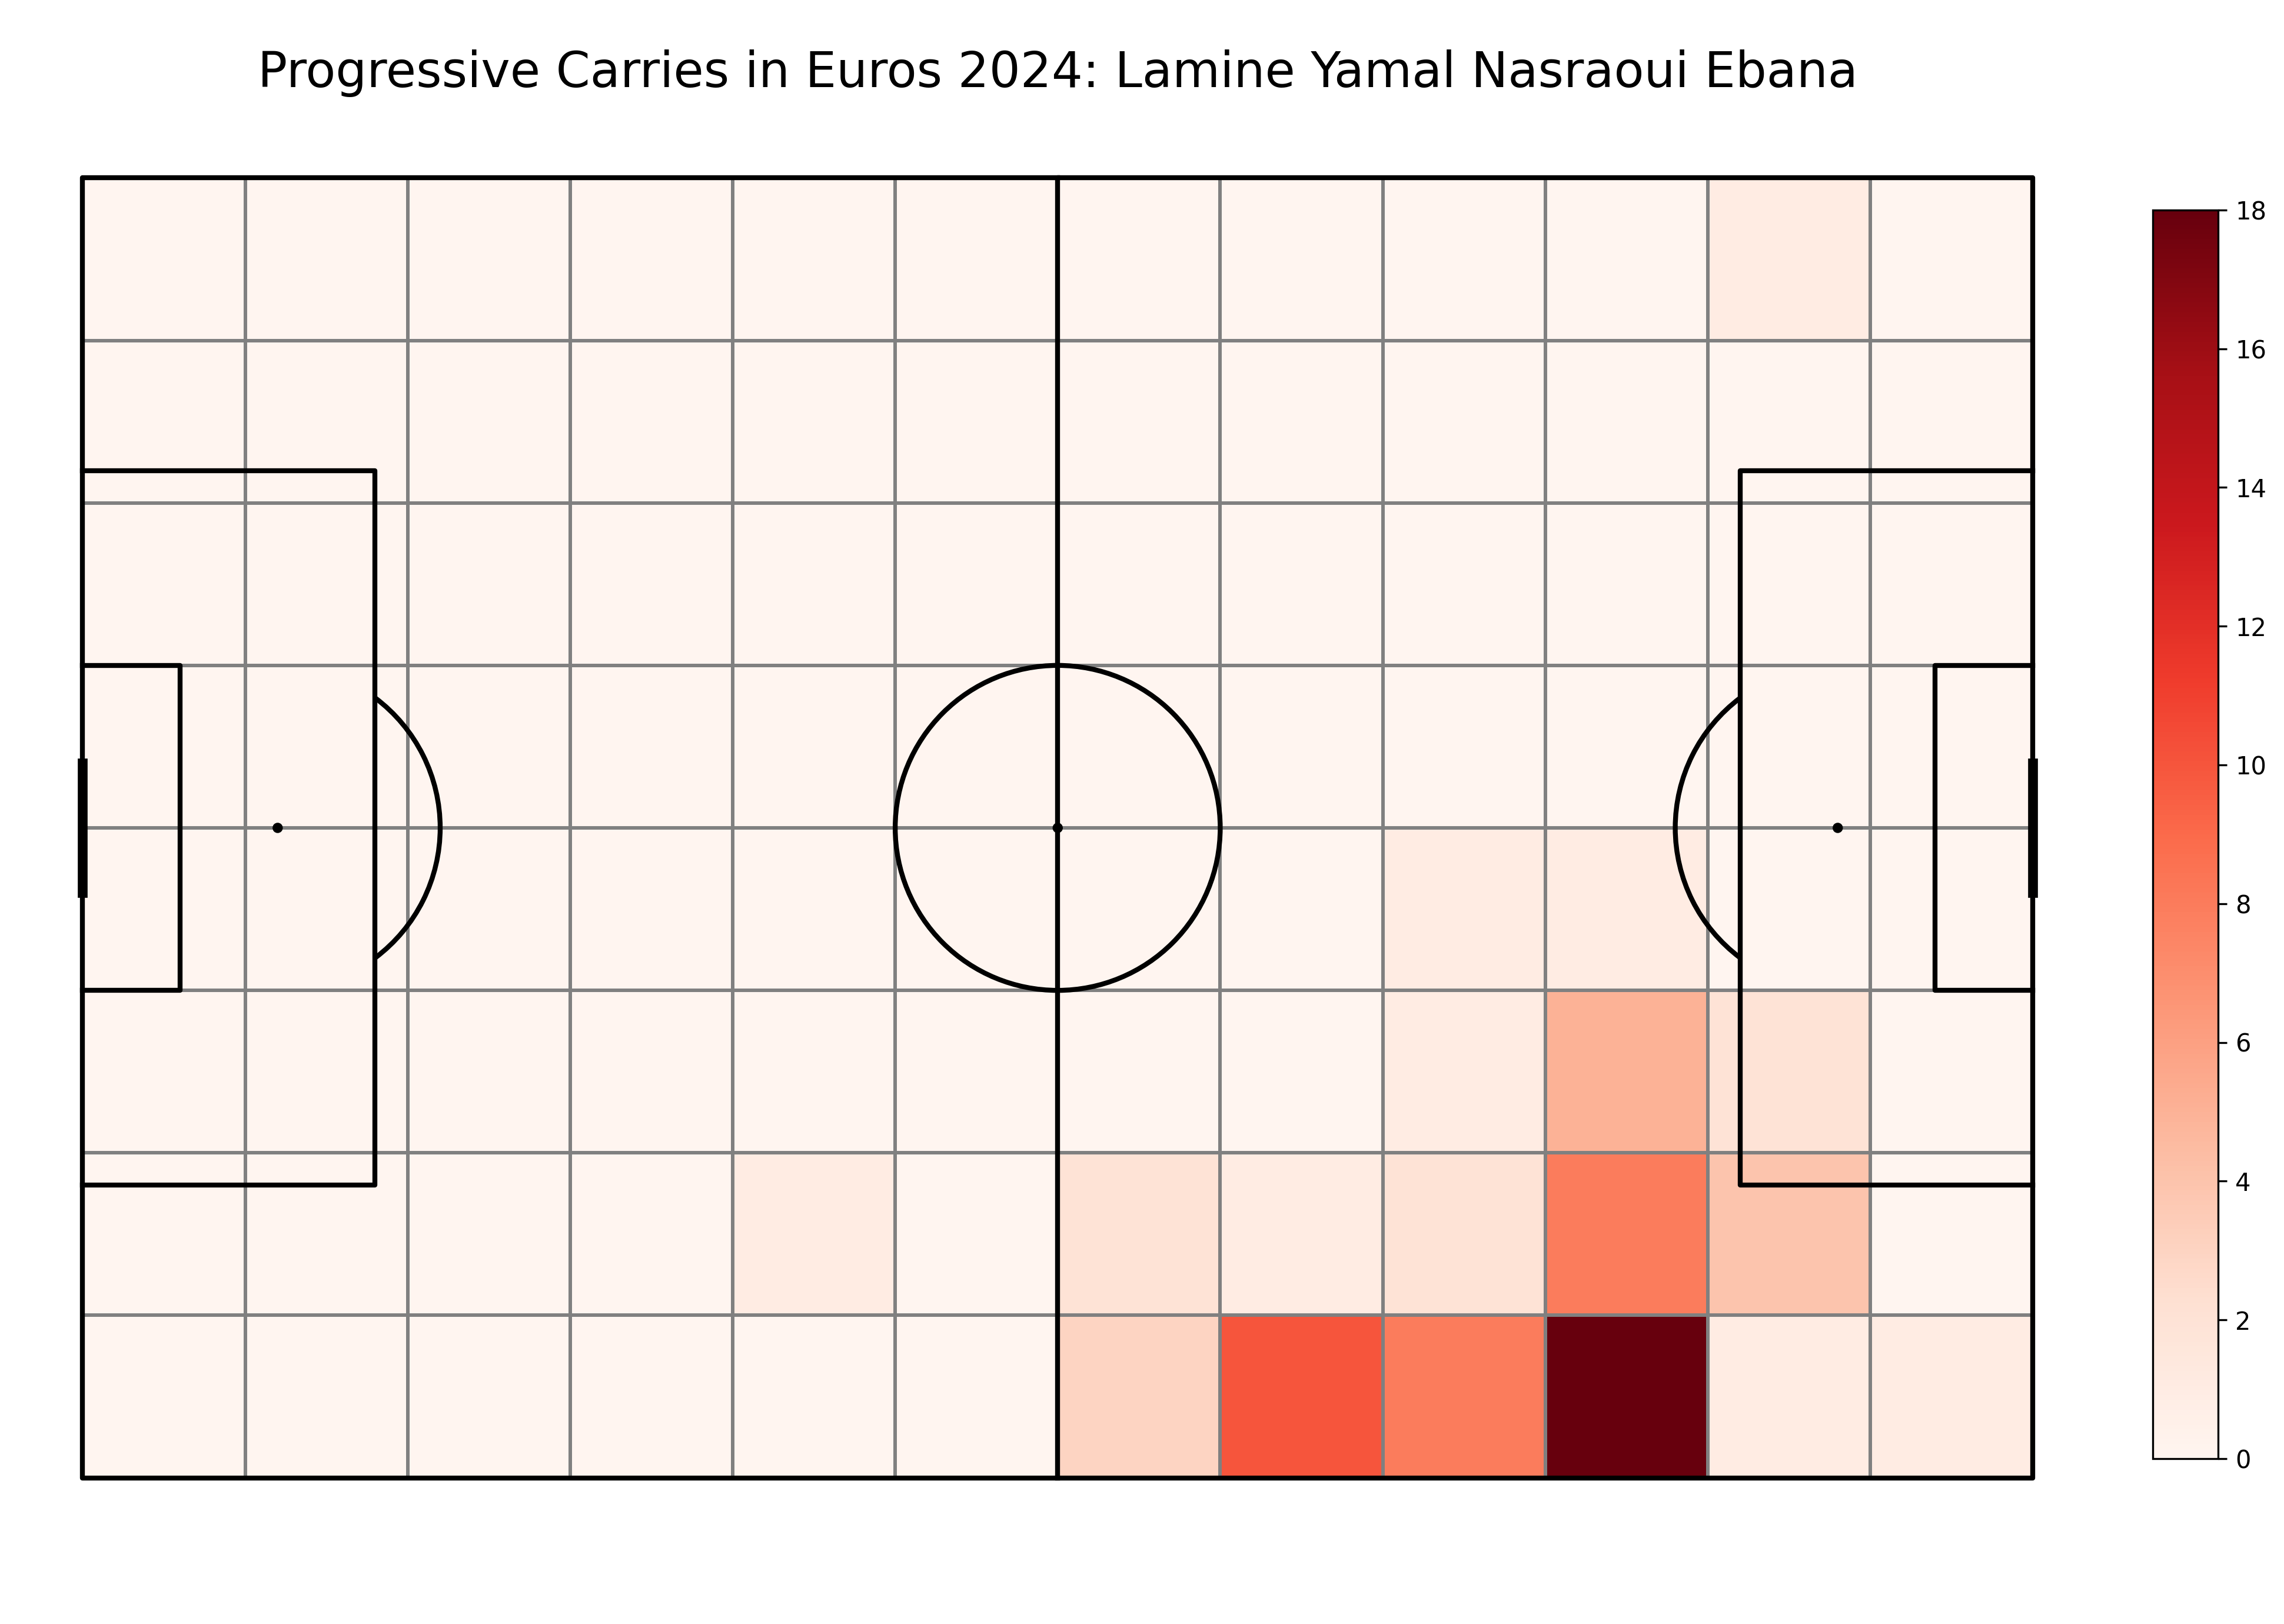

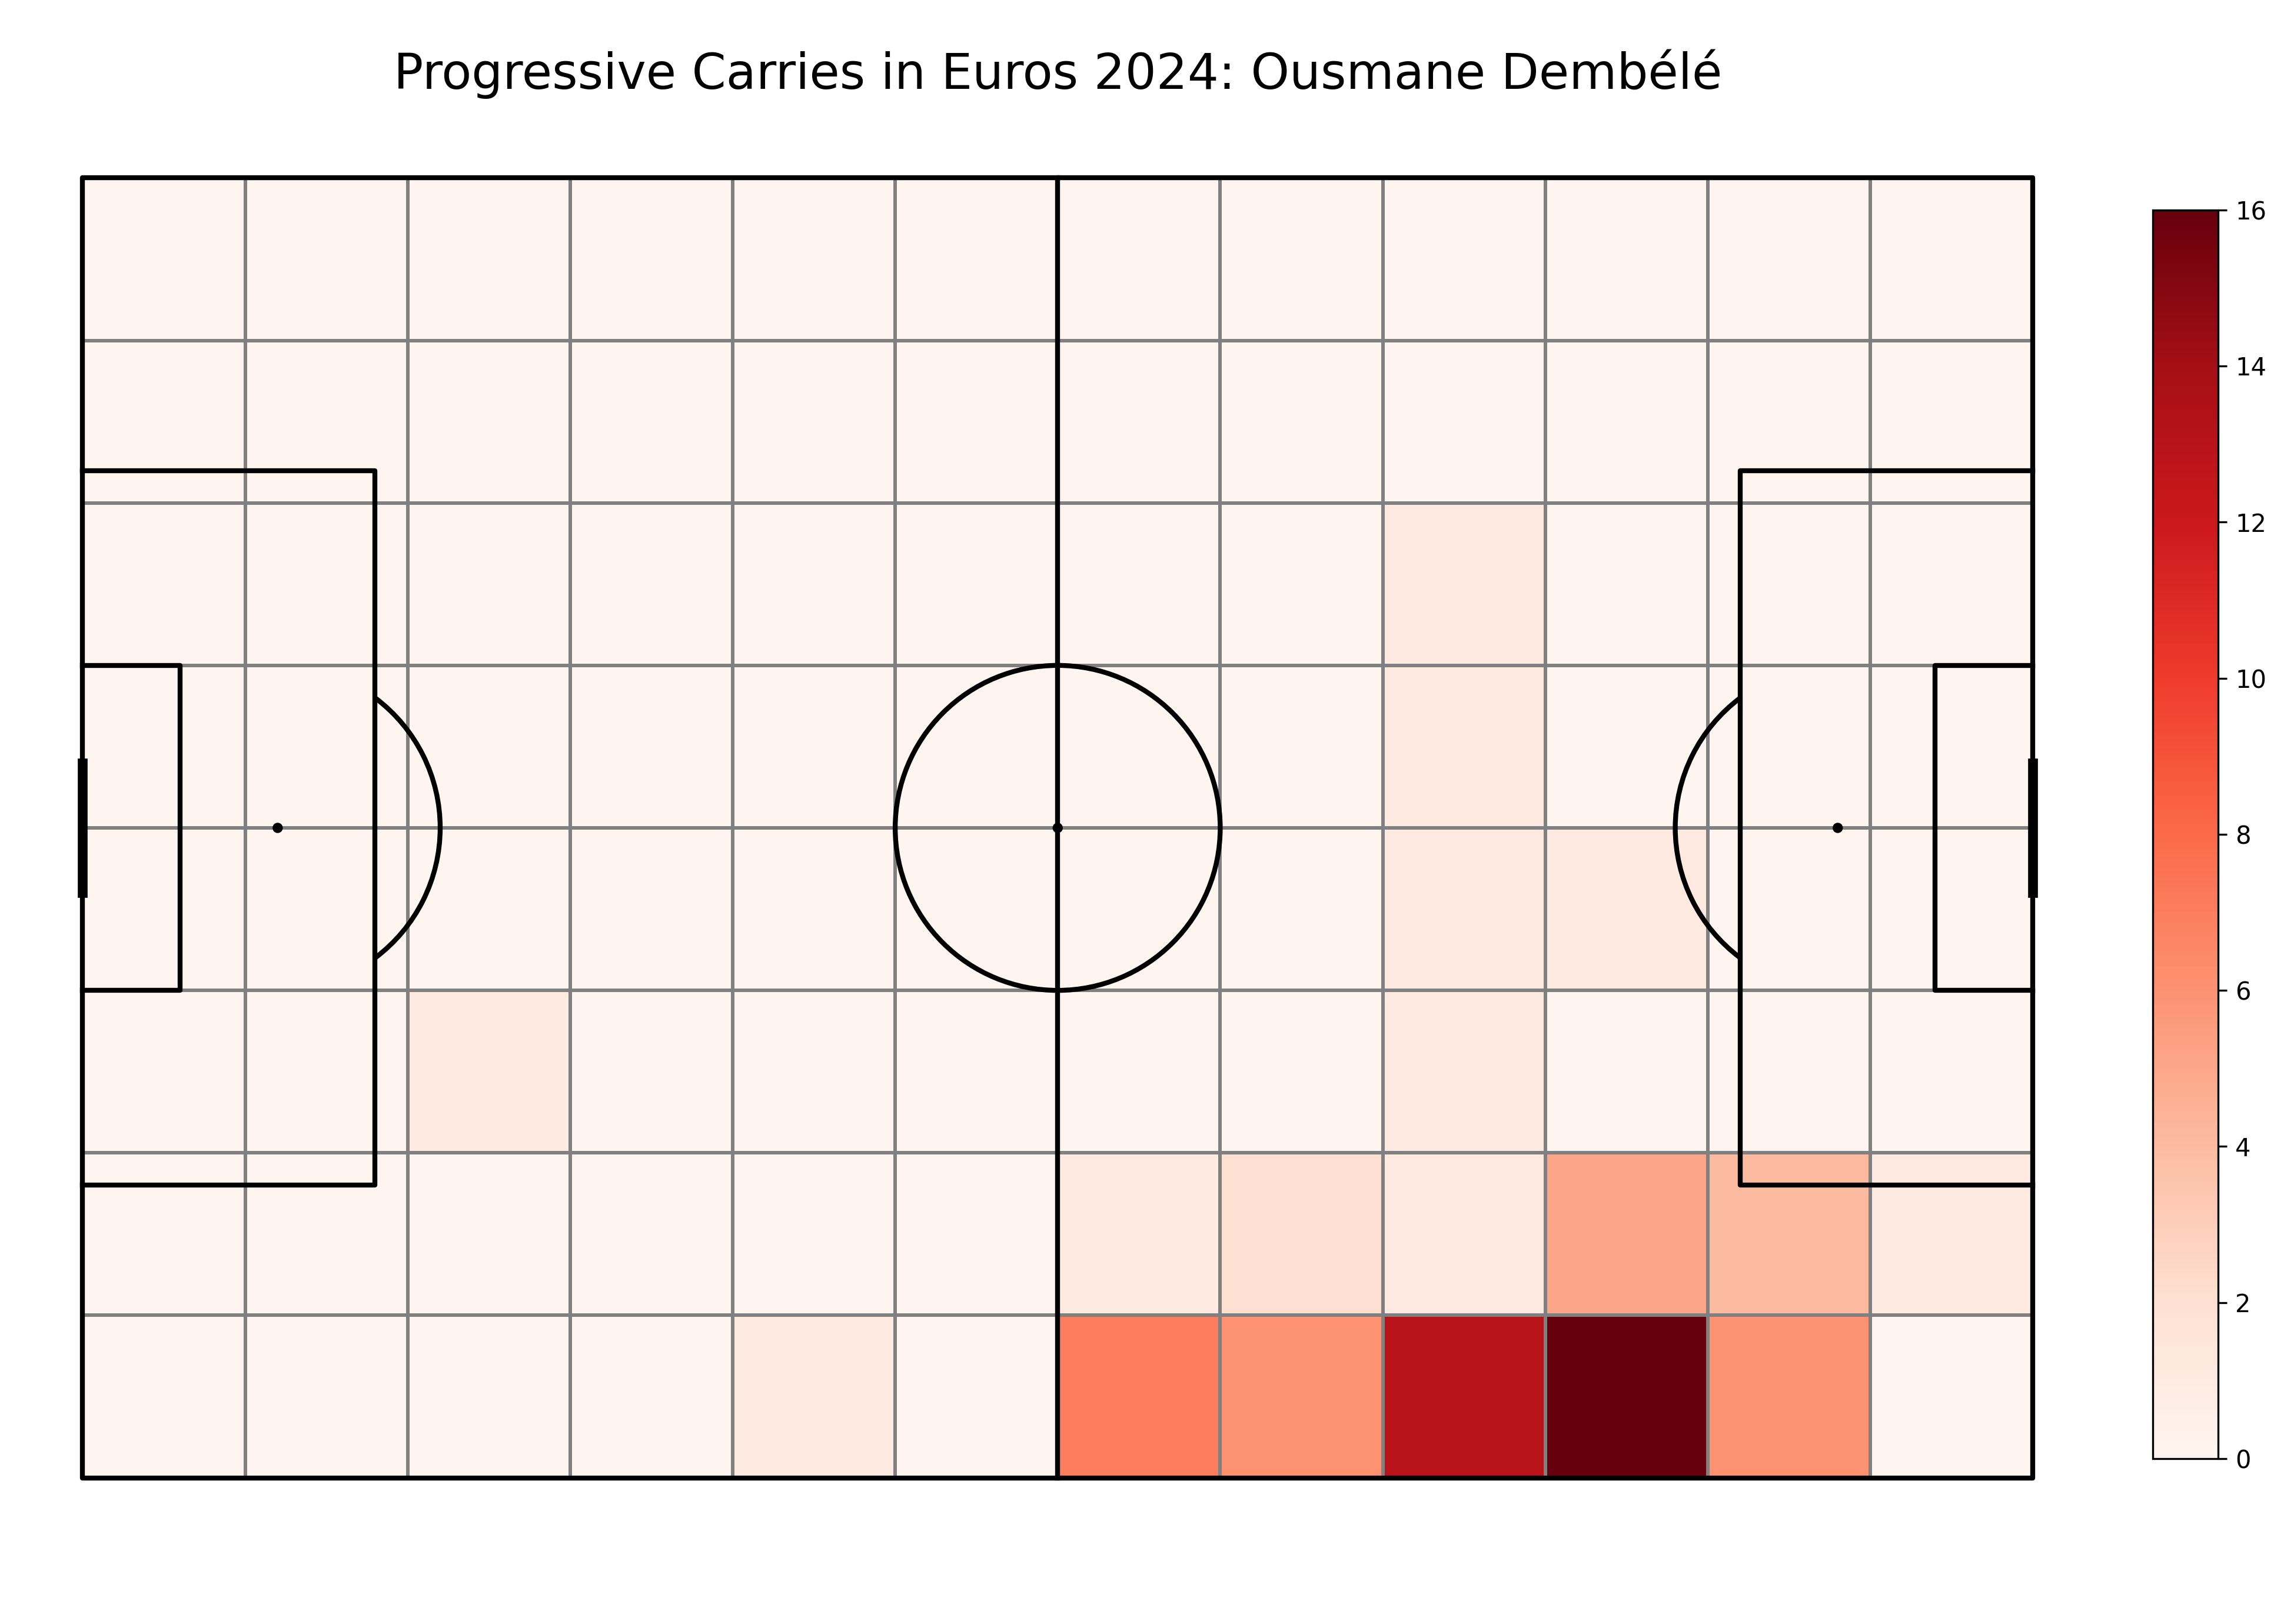

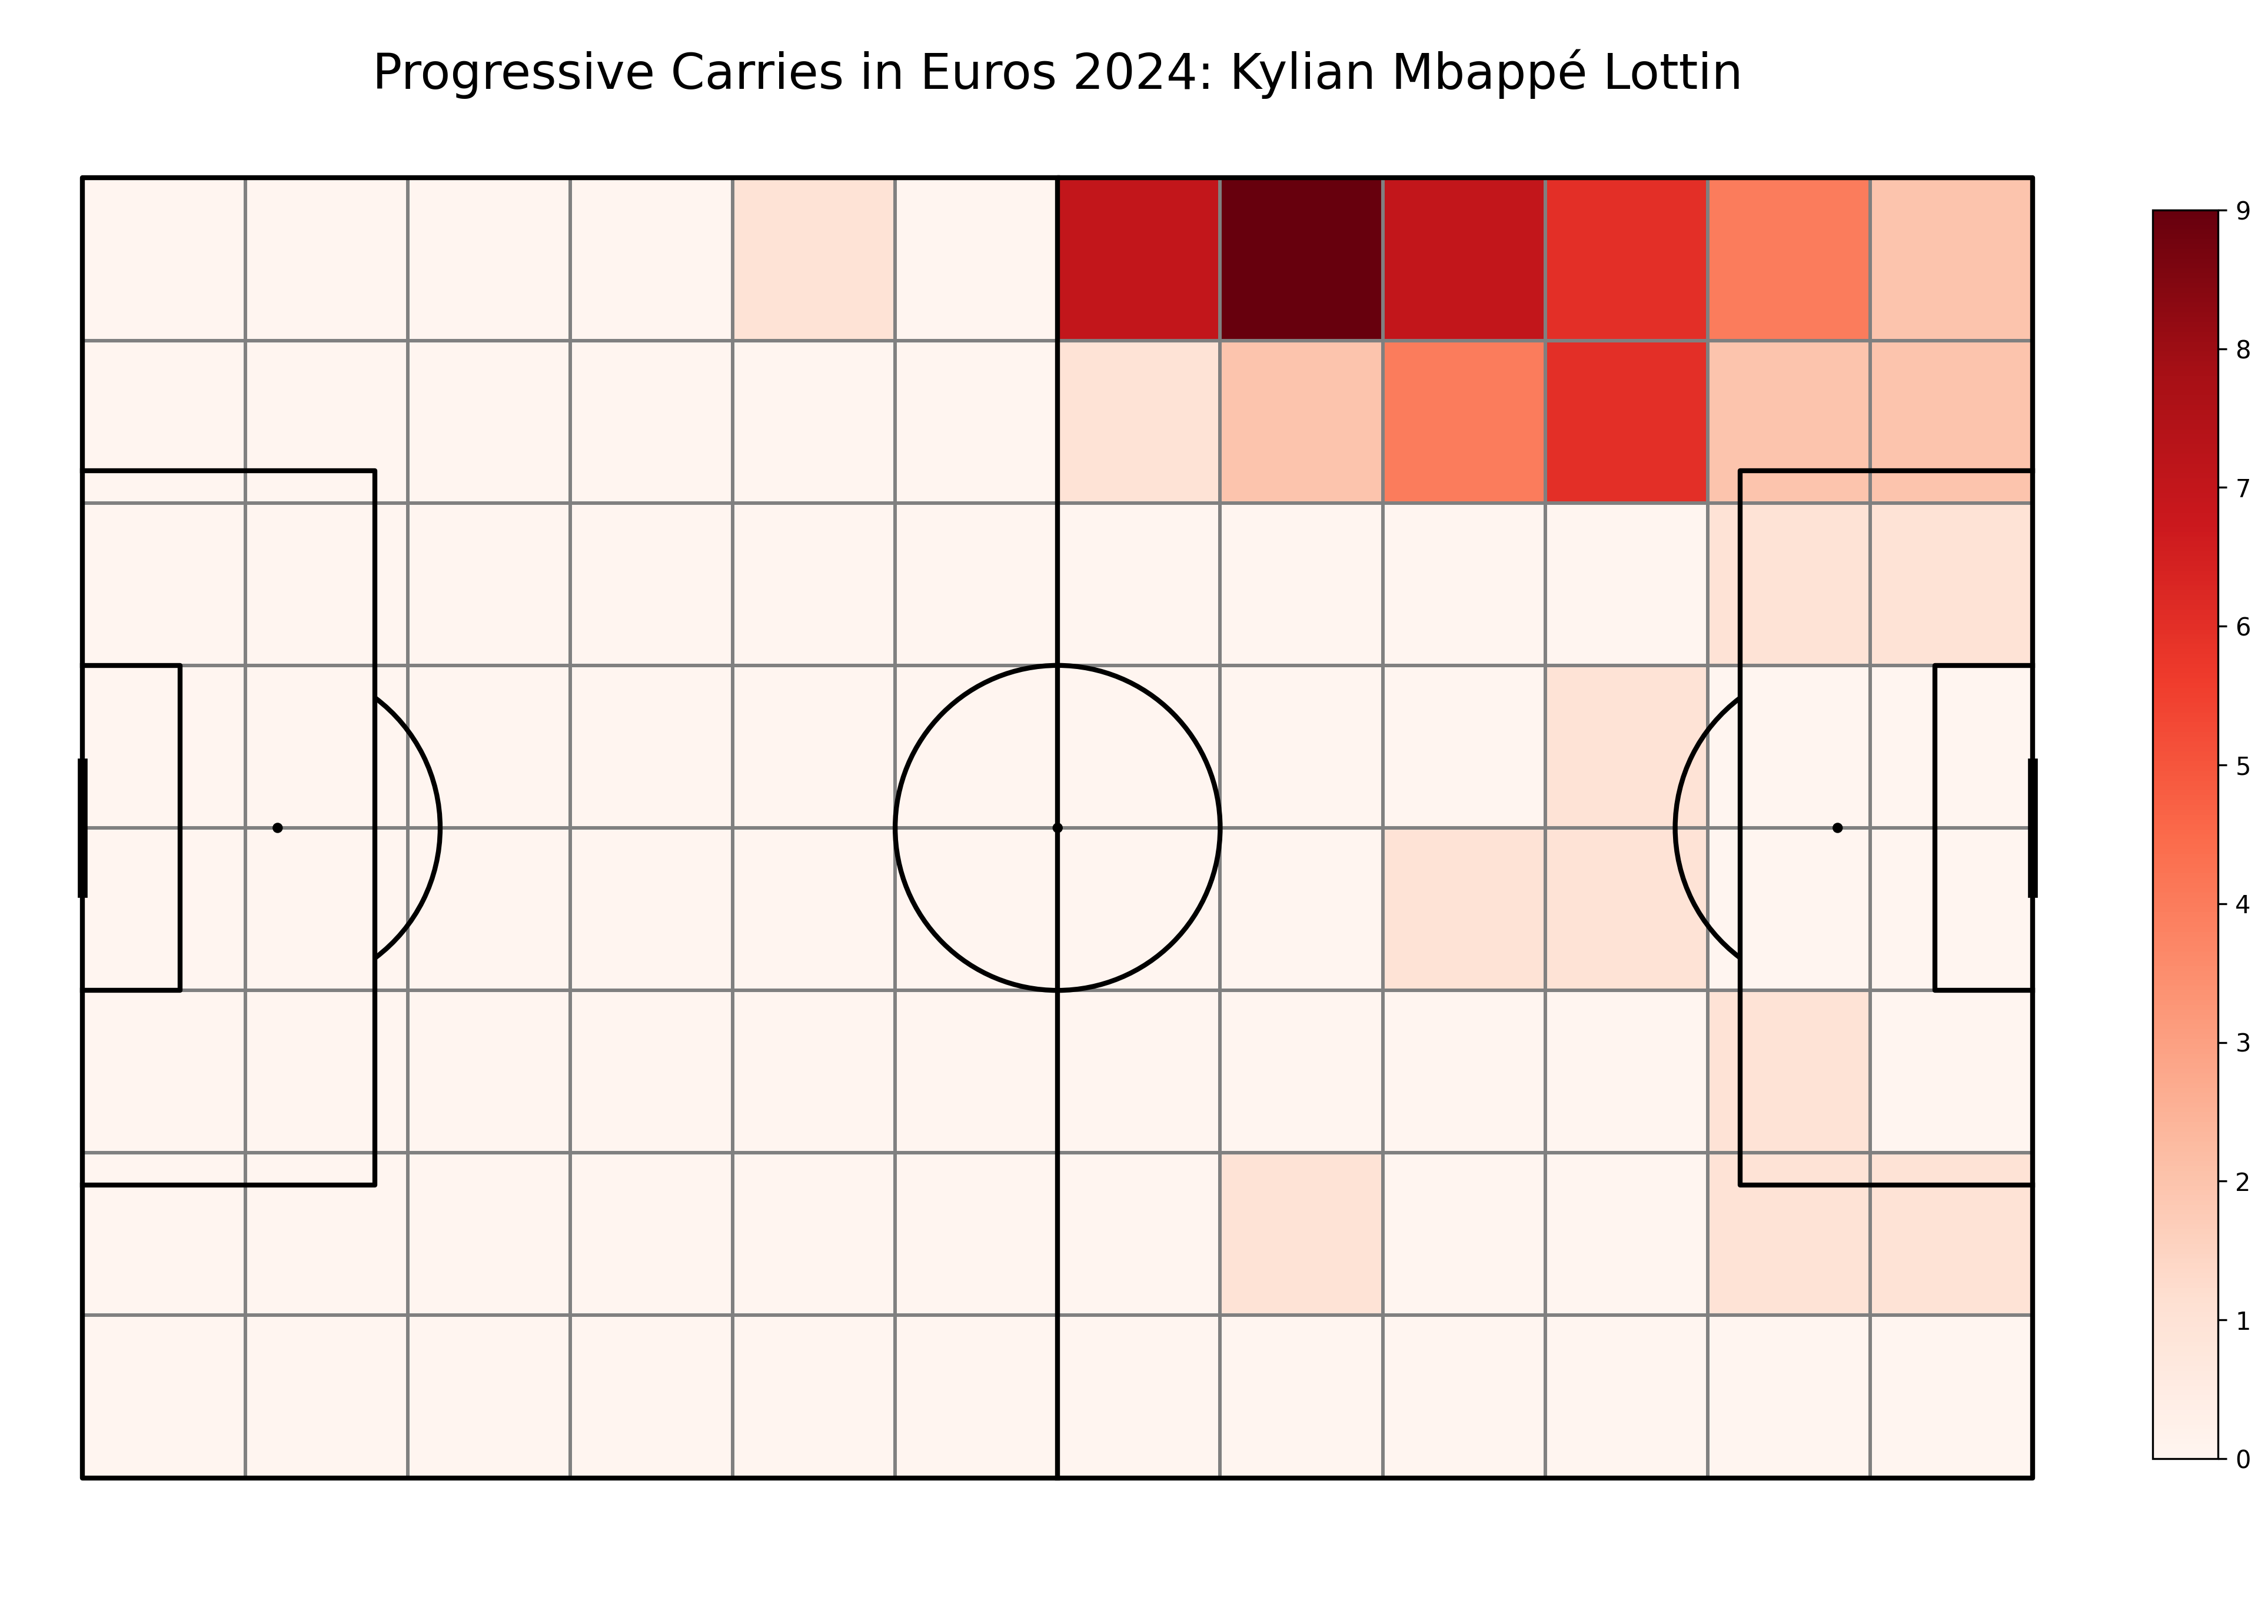

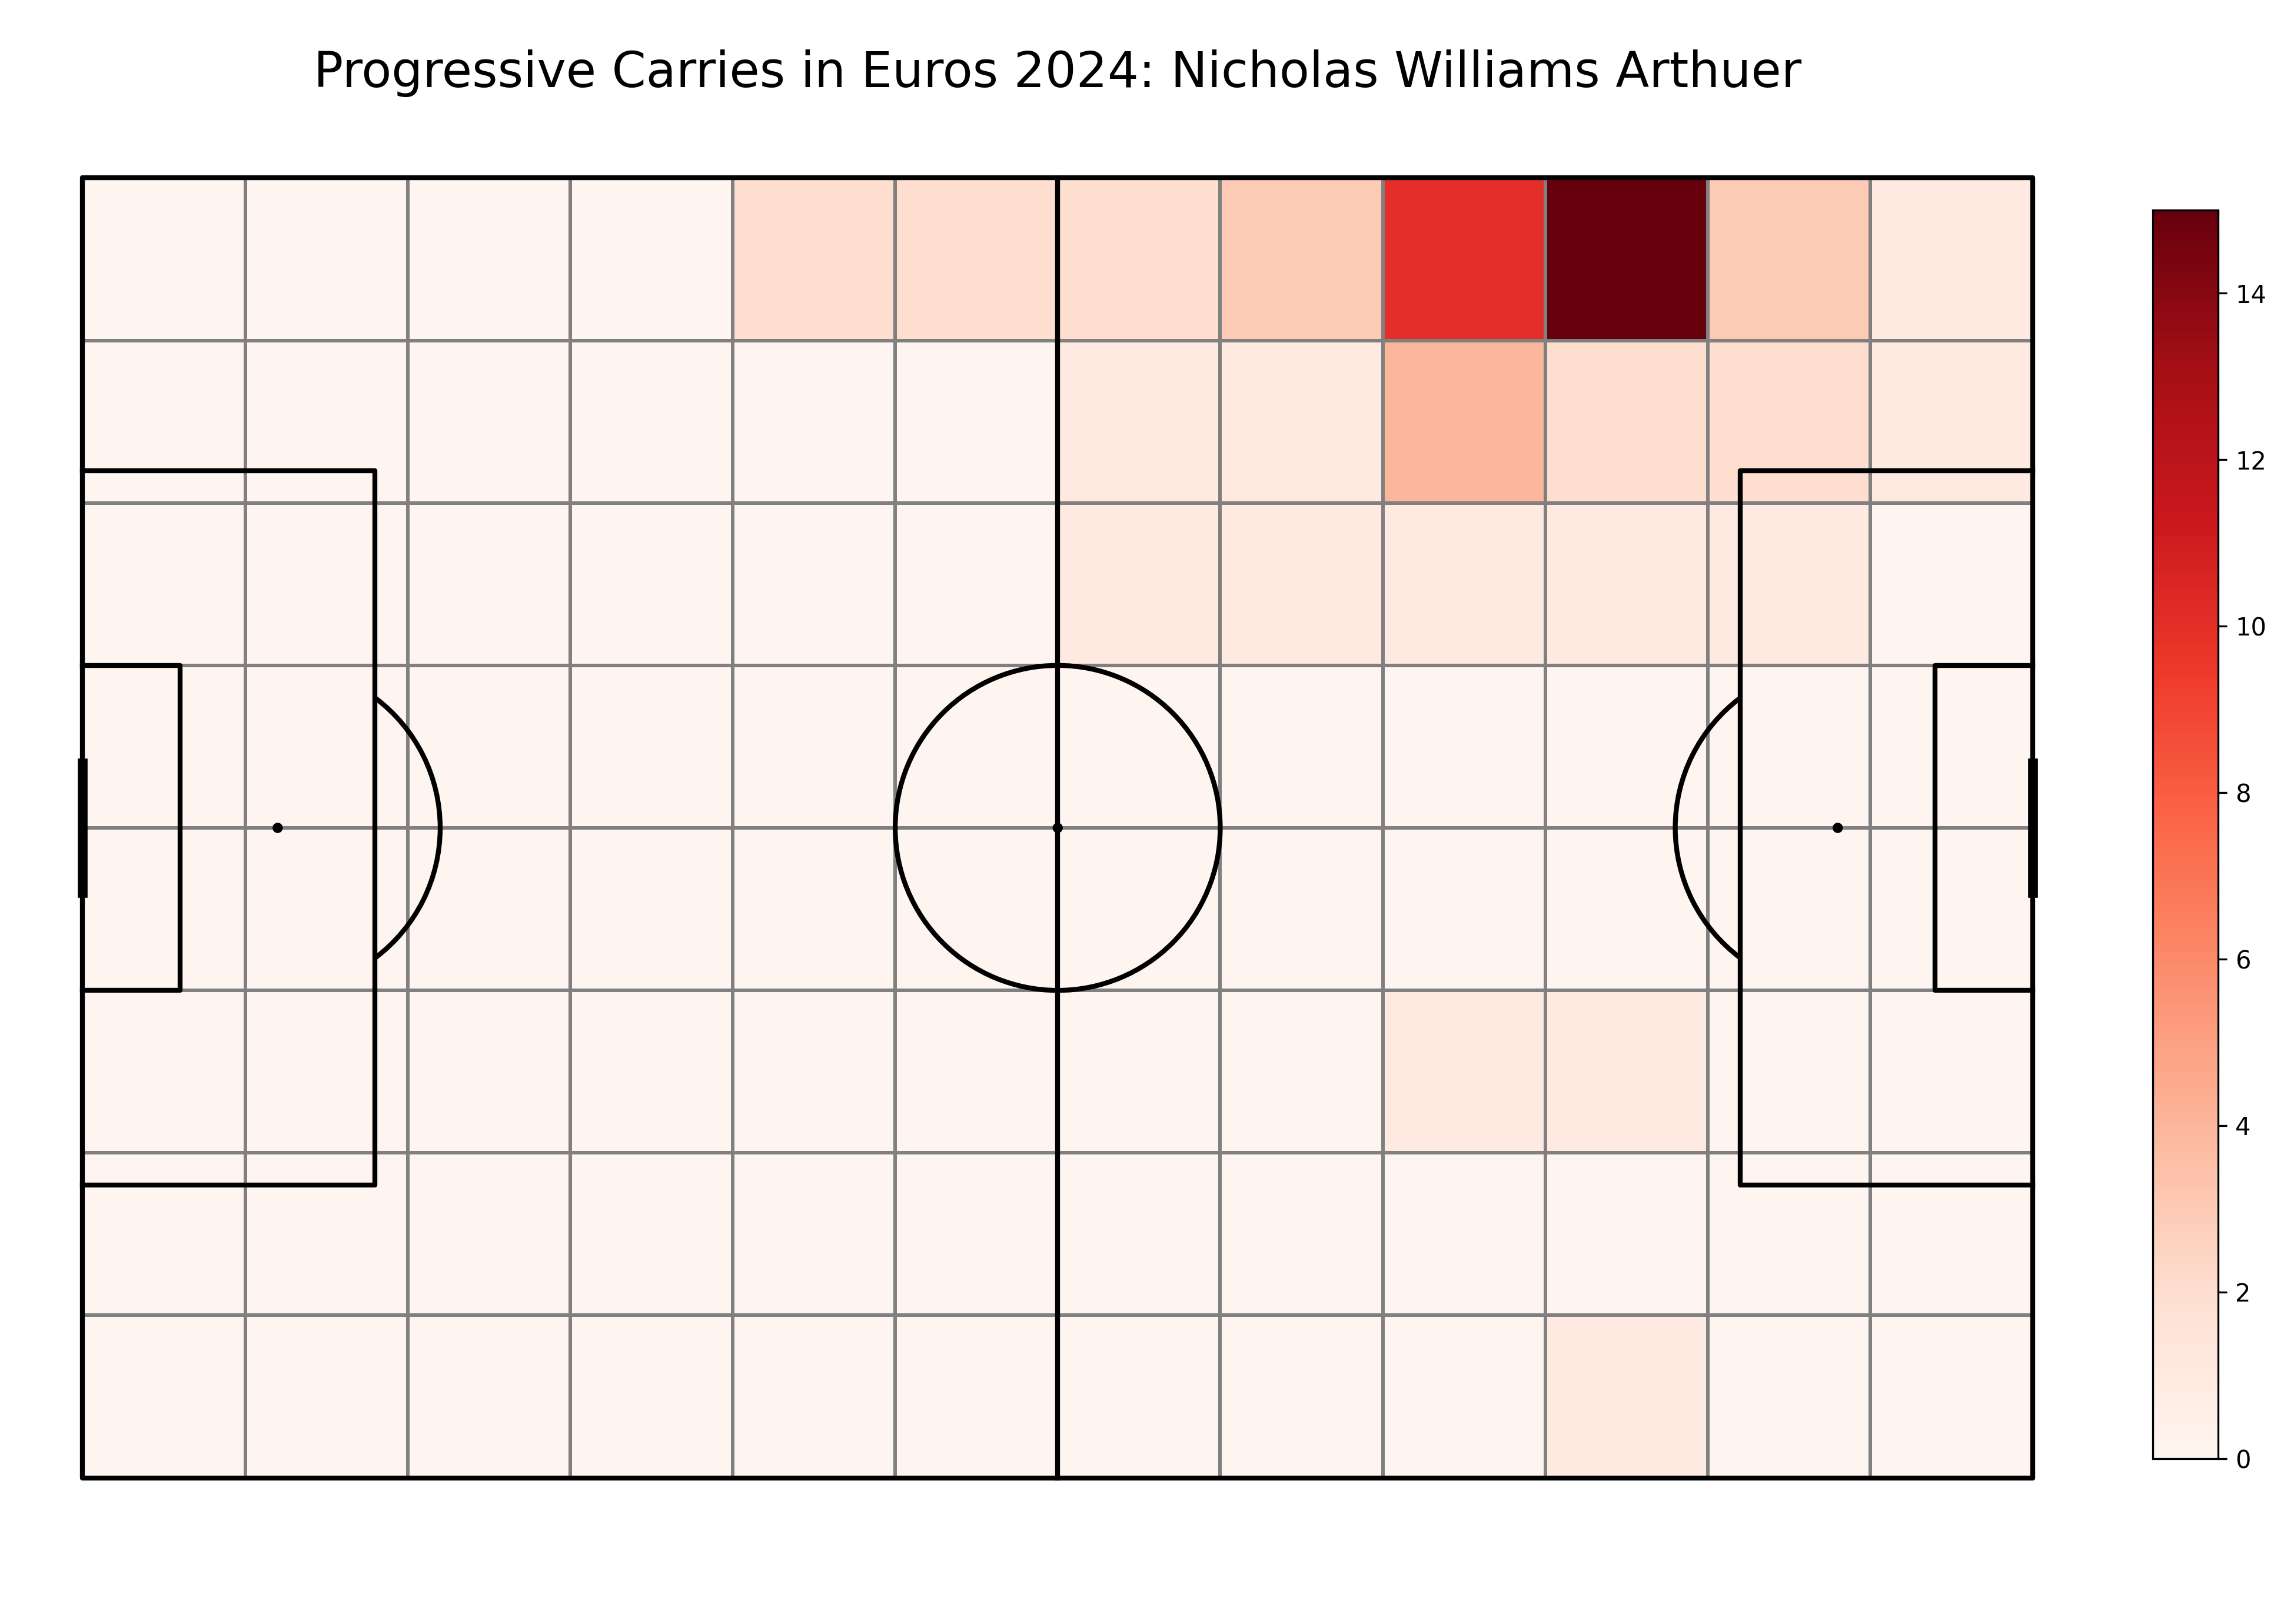

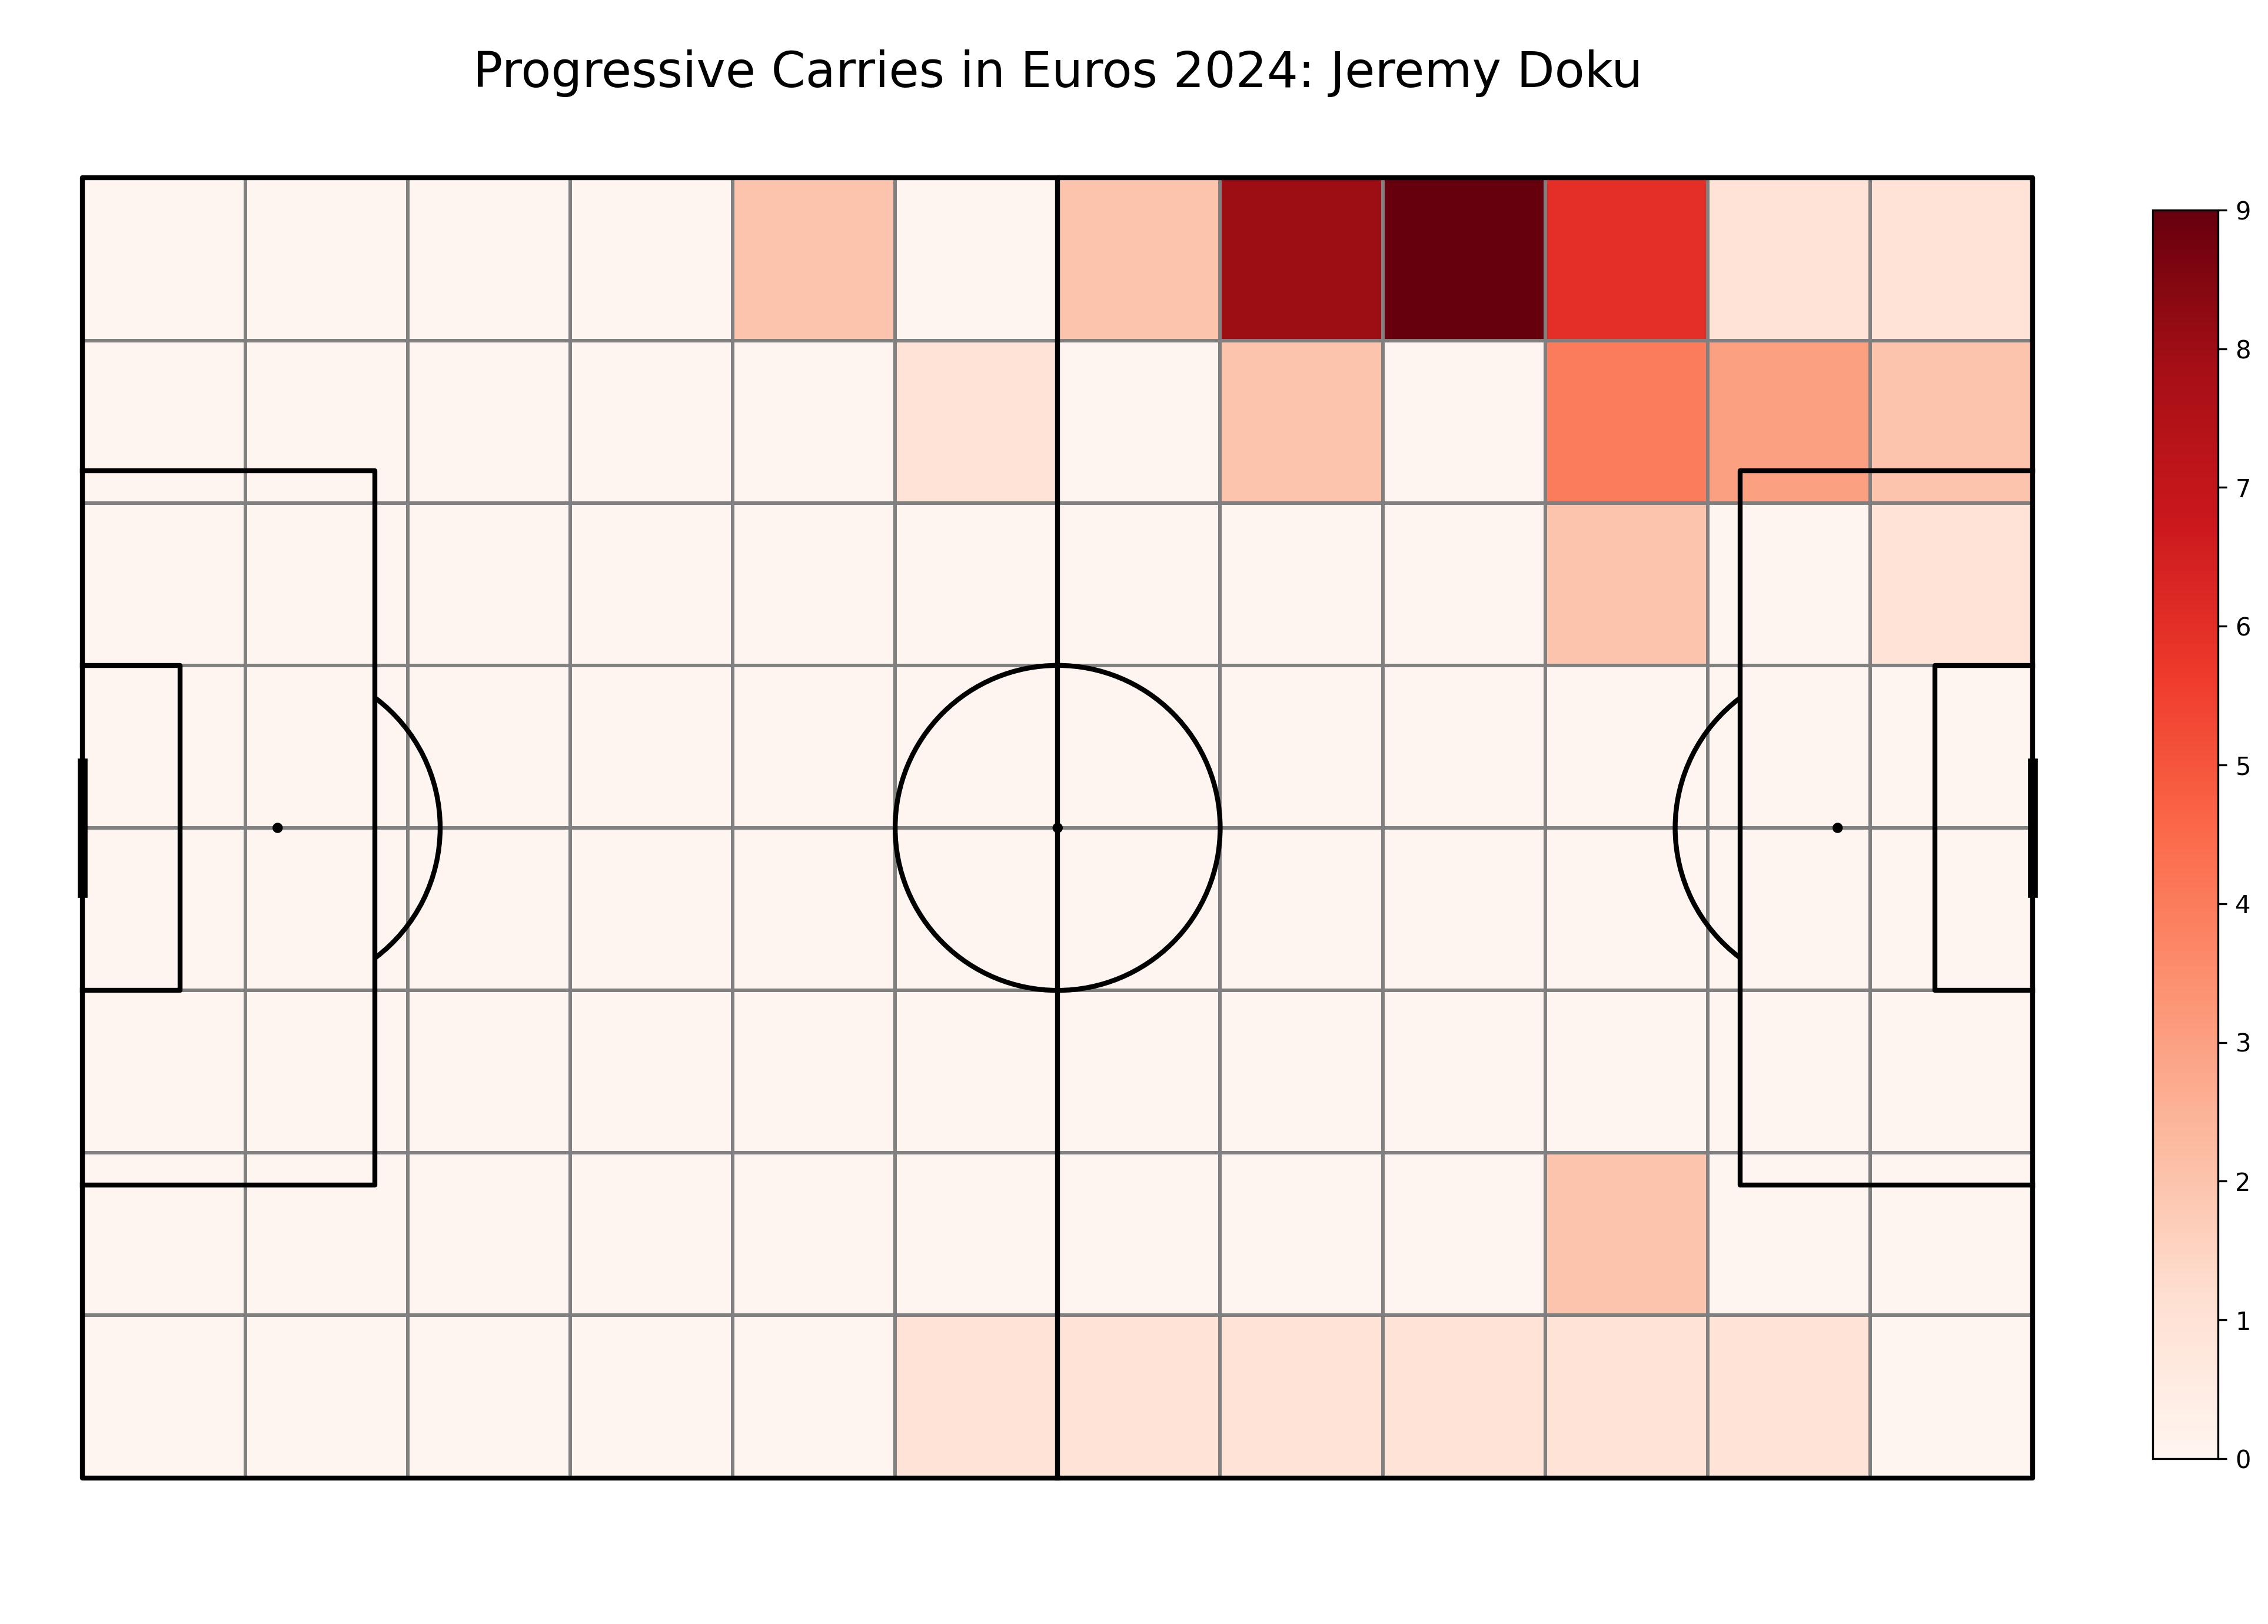

In [19]:
top6_carriers = prog_carriers.sort_values('prog_carries', ascending = False).head(6)['player_name'].tolist()

# plotting individually
for player in top6_carriers:
    # filter event-level df
    player_df = df_carry[(df_carry['player_name'] == player) & (df_carry['progressive'])]

    # creating pitch
    pitch = Pitch(line_zorder=2, line_color='black')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    fig.set_dpi(300)

    # 2D histogram
    bin_statistic = pitch.bin_statistic(player_df.x, player_df.y, statistic='count', bins=(12,8), normalize=False)

    # heatmap
    pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='#808080', ax=ax['pitch'])

    # colorbar
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)

    # title
    fig.suptitle('Progressive Carries in Euros 2024: ' + player, fontsize=20)
    plt.show()

In the next section, I've created a combined dataframe for top passers and carriers to check how they perform on BOTH the scales using a scatterplot

In [31]:
prog_combined = pd.merge(
    leaderboard_passes[['player_name', 'team_name', 'minutes_played', 'passes_per_90']],
    leaderboard_carries[['player_name', 'carries_per_90']],
    on='player_name'
)

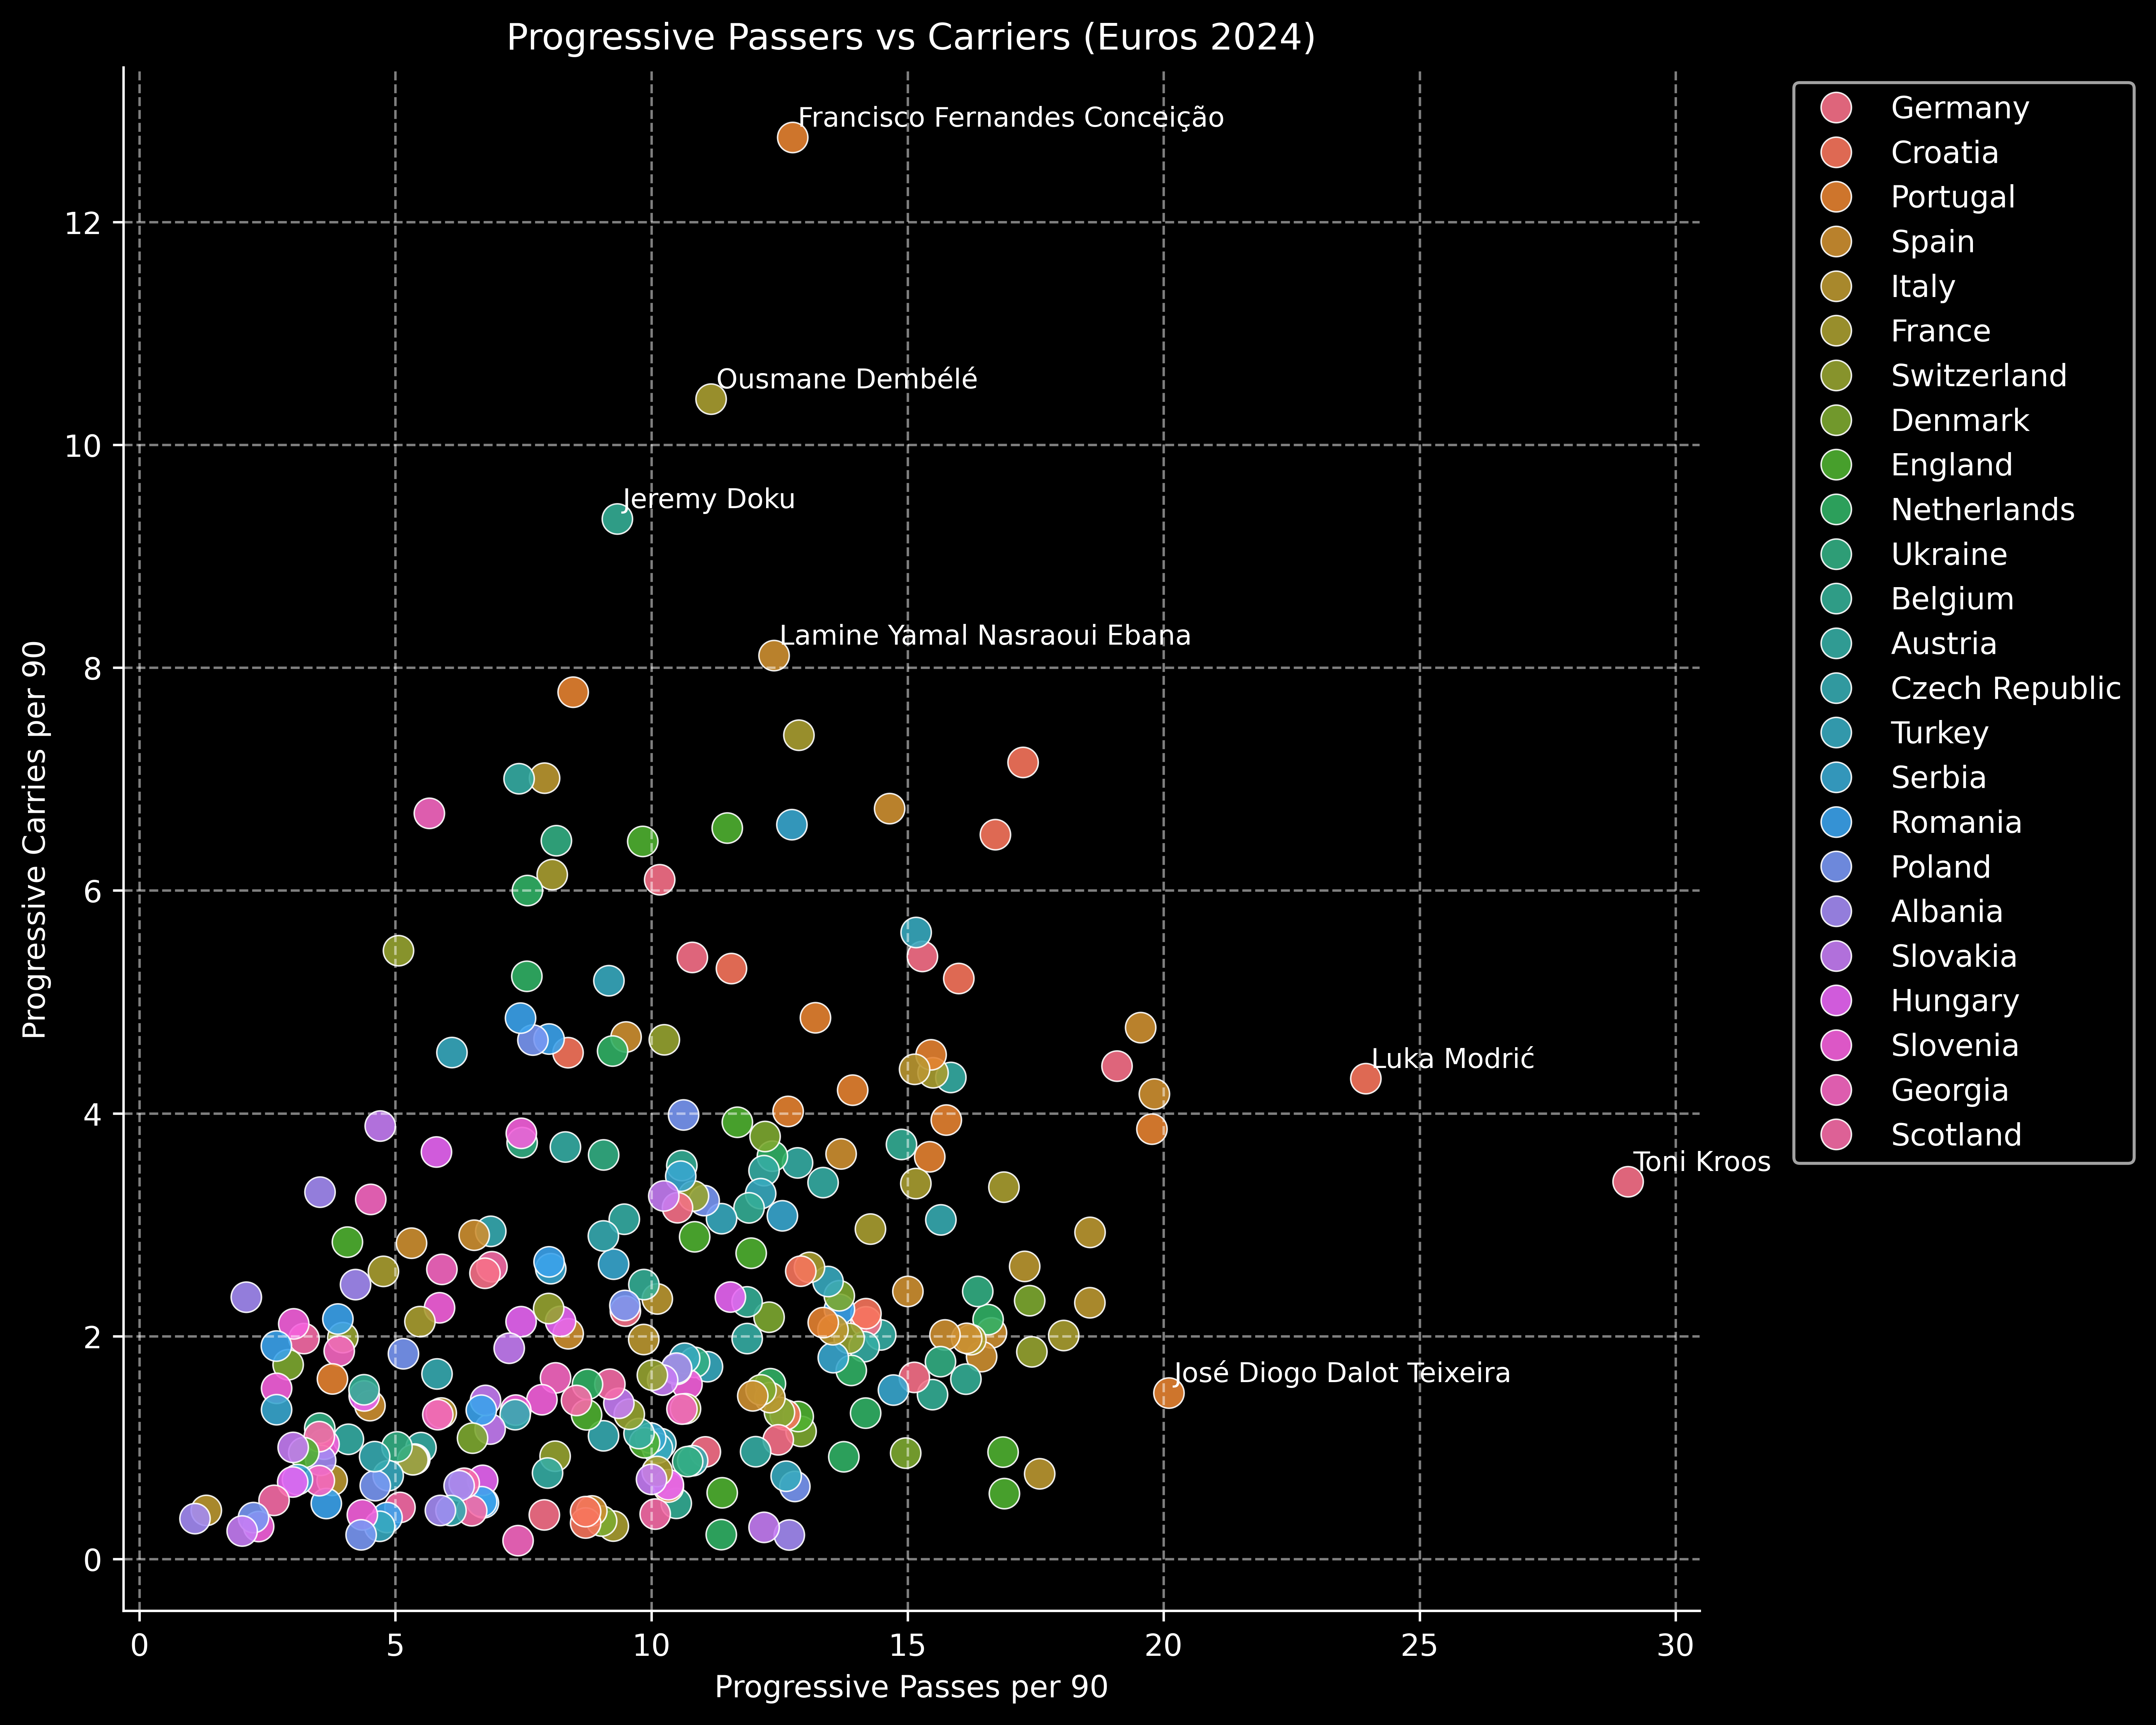

In [50]:
plt.style.use("dark_background")  # dark theme

plt.figure(figsize=(10, 8), dpi = 600)

sns.scatterplot(
    data = prog_combined,
    x='passes_per_90',
    y = 'carries_per_90',
    hue = 'team_name',
    s = 100, alpha = 0.9, edgecolor = 'white', linewidth = 0.5
)

# adding labels for standout players
for i, row in prog_combined.iterrows():
    if row['passes_per_90'] > 20 or row['carries_per_90'] > 8: # thresholds can be tweaked acc to purpose
        plt.text(row['passes_per_90']+0.1, row['carries_per_90']+0.1,
                 row['player_name'], fontsize = 9, color = 'white')

plt.xlabel('Progressive Passes per 90', color = 'white')
plt.ylabel('Progressive Carries per 90', color = 'white')
plt.title('Progressive Passers vs Carriers (Euros 2024)', color = 'white')
plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.grid(True, linestyle='--', alpha=0.5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()